## Accelerate Inference: Neural Network Pruning

In [2]:
import os
import numpy as np
import cv2
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import copy

import matplotlib.pyplot as plt


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [184]:
# # untar
# !ls
# !tar -xvzf dataset.tar.gz

CNN_pruning_students_pytorch.ipynb
CNN_pruning_students_pytorch.ipynb:Zone.Identifier
Dep_Graph_Based_Pruning.ipynb
Dep_Graph_Based_Pruning2.ipynb
Magnitude_Based_Pruning.ipynb
Magnitude_Pruning_Pareto_Graphs.ipynb
dataset
dataset.tar.gz
dataset.tar.gz:Zone.Identifier
my_model_weights_1.pt
train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl
train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [4]:
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

In [5]:
train_images = torch.tensor(train_images, dtype=torch.float32)
val_images = torch.tensor(val_images, dtype=torch.float32)

train_images = train_images.permute(0, 3, 1, 2)
val_images = val_images.permute(0, 3, 1, 2)

In [6]:
train_dataset = TensorDataset(train_images,
                              torch.tensor(train_labels.squeeze(), dtype=torch.long))
val_dataset = TensorDataset(val_images,
                            torch.tensor(val_labels.squeeze(), dtype=torch.long))

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.model = nn.Sequential(
            # First block: Conv -> ReLU -> Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Second block: Conv -> ReLU -> Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Flatten layer
            nn.Flatten(),

            # Fully connected block: Dense -> ReLU -> Dropout -> Dense -> Softmax
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5),
        )

    def forward(self, x):
        return self.model(x)

In [9]:
def get_dep_graph(layers):
    L = len(layers)
    D = torch.full((2*L, 2*L), False)

    for i, layer_i in enumerate(layers):
        for j, layer_j in enumerate(layers):
            dep = (j+1 == i) or (i==j and not(isinstance(layer_i, (nn.Linear, nn.Conv2d))))
            D[i*2, j*2+1] = dep
            D[j*2+1, i*2] = dep

    G = set()
    all_nodes = {i for i in range(2*L)}
    for i in range(2*L):
        g = {i,}
        gp = {1,}
        while len(gp) > 0:
            unseen = all_nodes - g
            gp = set()
            for j in unseen:
                for k in g:
                    if D[k, j]:
                        gp.add(j)
            g = g.union(gp)
        G.add(frozenset(g))

    return G

In [10]:
model = ConvNet()
layers = [i for i in next(model.children()).children()]
G_og = get_dep_graph(layers)
G = {g for g in G_og if 0 not in g and len(layers)*2-1 not in g}

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

In [11]:
model = model.to(device)
summary(model, input_size=(3, 25, 25))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             896
              ReLU-2           [-1, 32, 25, 25]               0
            Conv2d-3           [-1, 32, 23, 23]           9,248
              ReLU-4           [-1, 32, 23, 23]               0
         MaxPool2d-5           [-1, 32, 11, 11]               0
           Dropout-6           [-1, 32, 11, 11]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
            Conv2d-9             [-1, 64, 9, 9]          36,928
             ReLU-10             [-1, 64, 9, 9]               0
        MaxPool2d-11             [-1, 64, 4, 4]               0
          Dropout-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [12]:
for g in sorted(G, key=lambda x: min(x)):
    for l in sorted(g):
        print(l, layers[l//2], end=' ')
        print('Out' if l%2 else 'In', end=', ')
    print('')

1 Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Out, 2 ReLU() In, 3 ReLU() Out, 4 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)) In, 
5 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)) Out, 6 ReLU() In, 7 ReLU() Out, 8 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) In, 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Out, 10 Dropout(p=0.25, inplace=False) In, 11 Dropout(p=0.25, inplace=False) Out, 12 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) In, 
13 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Out, 14 ReLU() In, 15 ReLU() Out, 16 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)) In, 
17 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)) Out, 18 ReLU() In, 19 ReLU() Out, 20 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) In, 21 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Out, 22 Dropout(p=0.25, inplace=False)

In [13]:
def _get_param_importance(layer, is_output_pruning):
    if not isinstance(layer, (nn.Conv2d, nn.Linear)):
        return None  # Non-parameterized layers (ReLU, etc.) contribute nothing to norm

    w = layer.weight
    if is_output_pruning:
        dims_to_sum = tuple(range(1, w.dim()))
    else:
        dims_to_sum = (0,) + tuple(range(2, w.dim()))
    return w.pow(2).sum(dim=dims_to_sum)

def get_group_norm(group, layers):
    ref_size = None
    raw_importances = []
    
    for node_idx in group:
        layer = layers[node_idx // 2]
        imp = _get_param_importance(layer, is_output_pruning=node_idx % 2 == 1)
        
        if imp is not None:
            raw_importances.append(imp)

    if len(raw_importances) == 0:
        return None

    ref_size = min(imp.shape[0] for imp in raw_importances)

    # Aggregate / Fold vectors that are larger than ref_size
    final_group_imp = torch.zeros(ref_size, device=layers[0].weight.device)
    
    for imp in raw_importances:
        current_size = imp.shape[0]
        if current_size == ref_size:
            final_group_imp += imp
            
        elif current_size > ref_size and current_size % ref_size == 0:
            spatial_size = current_size // ref_size
            folded_imp = imp.view(ref_size, spatial_size).sum(dim=1)
            
            final_group_imp += folded_imp
            
        else:
            print(f"Warning: Dimension mismatch in group (Ref: {ref_size}, Found: {current_size}). "
                  "Skipping this connection as it is likely not structurally prunable.")
            
    return final_group_imp

def get_depgraph_reg_loss(layers, G, alpha=4.0):
    reg_loss = 0.0
    
    for group in G:
        # Eq (4)
        I_g_k = get_group_norm(group, layers)
        
        # Skip groups with no parameterized layers
        if I_g_k is None:
            continue
        max_imp = I_g_k.max()
        min_imp = I_g_k.min()
        denom = max_imp - min_imp + 1e-8
        normalized_score = (max_imp - I_g_k) / denom
        gamma_k = 2 ** (alpha * normalized_score)
        group_reg = (gamma_k * I_g_k).sum()
        
        reg_loss += group_reg
        
    return reg_loss

In [14]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, reg_weight=0, masks=None, zero_optimizer_state_fn=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, (inputs, labels) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if reg_weight > 0:
            loss += reg_weight * get_depgraph_reg_loss(layers, G)
        # print(criterion(outputs, labels), get_depgraph_reg_loss(layers, G))

        loss.backward()
        optimizer.step()
        
        if masks is not None:
            with torch.no_grad():
                for layer, mask_dict in masks.items():
                    layer.weight.data.mul_(mask_dict['weight'])
                    if mask_dict['bias'] is not None:
                        layer.bias.data.mul_(mask_dict['bias'])

            if zero_optimizer_state_fn is not None:
                zero_optimizer_state_fn(optimizer, masks)

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=running_loss / total, accuracy=100 * correct / total)

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    return train_loss, train_accuracy

In [15]:
def validate(model, val_loader, criterion, device, reg_weight=0):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if reg_weight > 0:
                loss += reg_weight * get_depgraph_reg_loss(layers, G)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            val_loader_tqdm.set_postfix(loss=val_loss / total, accuracy=100 * correct / total)

    val_accuracy = 100 * correct / total
    val_loss = val_loss / len(val_loader)
    return val_loss, val_accuracy

In [16]:
def prune_and_freeze(layers, G, pruning_ratio=0.5):
    # Dictionary to store masks so we can combine input/output decisions
    # Key: layer object, Value: {'weight': tensor, 'bias': tensor}
    masks = {}
    
    # Initialize masks for all parameterized layers to 1 (Keep All)
    for layer in layers:
        if isinstance(layer, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
            masks[layer] = {
                'weight': torch.ones_like(layer.weight),
                'bias': torch.ones_like(layer.bias) if layer.bias is not None else None
            }

    with torch.no_grad():
        for group in G:
            # Calculate Group Importance
            I_g_k = get_group_norm(group, layers)
            if I_g_k is None: continue
            
            # Determine Indices to Prune
            num_channels = len(I_g_k)
            num_to_keep = int(num_channels * (1 - pruning_ratio))
            if num_to_keep < 1: num_to_keep = 1
            
            _, keep_indices = torch.topk(I_g_k, k=num_to_keep)
            
            # Generate Boolean Mask (False = Prune)
            channel_mask = torch.zeros(num_channels, dtype=torch.bool, device=keep_indices.device)
            channel_mask[keep_indices] = True
            
            for node_idx in group:
                layer_idx = node_idx // 2
                is_output_node = (node_idx % 2 == 1)
                layer = layers[layer_idx]
                
                if layer not in masks: continue
                
                if is_output_node:
                    # Prune rows where channel_mask is False
                    masks[layer]['weight'][~channel_mask, ...] = 0.0
                    
                    if masks[layer]['bias'] is not None:
                        masks[layer]['bias'][~channel_mask] = 0.0
                        
                elif not is_output_node:
                    if isinstance(layer, (nn.BatchNorm2d, nn.BatchNorm1d)):
                        continue 

                    # Flatten needs to be handled manually
                    # final_mask_indices = torch.where(channel_mask)[0] # Indices to KEEP
                    if isinstance(layer, nn.Linear):
                        if layer.in_features > num_channels:
                            spatial_size = layer.in_features // num_channels
                            # Expand the boolean channel mask to spatial mask
                            expanded_mask = channel_mask.repeat_interleave(spatial_size)
                            
                            # Apply to Linear Input (Dim 1)
                            masks[layer]['weight'][:, ~expanded_mask] = 0.0
                            continue

                    # Standard Conv/Linear Input Pruning
                    if isinstance(layer, nn.Conv2d):
                        masks[layer]['weight'][:, ~channel_mask, :, :] = 0.0
                    elif isinstance(layer, nn.Linear):
                        masks[layer]['weight'][:, ~channel_mask] = 0.0

    # Apply Masks to Data, Register Hooks
    for layer, mask_dict in masks.items():
        w_mask = mask_dict['weight']
        layer.weight.data.mul_(w_mask)
        
        def get_weight_hook(mask):
            def hook(grad):
                return grad * mask
            return hook
            
        layer.weight.register_hook(get_weight_hook(w_mask))
        
        if mask_dict['bias'] is not None:
            b_mask = mask_dict['bias']
            layer.bias.data.mul_(b_mask)
            
            def get_bias_hook(mask):
                def hook(grad):
                    return grad * mask
                return hook
                
            layer.bias.register_hook(get_bias_hook(b_mask))

    print("Pruning applied. Gradients for pruned weights are now frozen.")
    return masks

In [17]:
def zero_optimizer_state_for_pruned_weights(optimizer, masks):
    for group in optimizer.param_groups:
        for param in group['params']:
            # Find the corresponding mask for this parameter
            param_mask = None
            for layer, mask_dict in masks.items():
                if layer.weight is param:
                    param_mask = mask_dict['weight']
                    break
                elif layer.bias is not None and layer.bias is param:
                    param_mask = mask_dict['bias']
                    break
            
            if param_mask is None:
                continue
            
            # Zero out optimizer state for pruned weights
            if param in optimizer.state:
                state = optimizer.state[param]
                if 'exp_avg' in state:
                    state['exp_avg'].mul_(param_mask)
                if 'exp_avg_sq' in state:
                    state['exp_avg_sq'].mul_(param_mask)
                if 'max_exp_avg_sq' in state:
                    state['max_exp_avg_sq'].mul_(param_mask)

In [ ]:
# Main training loop with early stopping based on validation loss
num_epochs = 200
reg_weight = 1e-4
patience = 10

# Track metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early stopping state
best_val_loss = float('inf')
best_val_accuracy = 0.0
best_state_dict = None
epochs_no_improve = 0
best_epoch = -1

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device, reg_weight)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device, reg_weight)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        best_epoch = epoch
    else:
        epochs_no_improve += 1

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement (epoch {epoch+1})")
        # Revert model to best state dict
        if best_state_dict is not None:
            model.load_state_dict(best_state_dict)
            print(f"Model reverted to epoch {best_epoch+1} with best val loss: {best_val_loss:.4f} "
                  f"and val accuracy: {best_val_accuracy:.2f}%")
        break

Epoch 1/50


KeyboardInterrupt: 

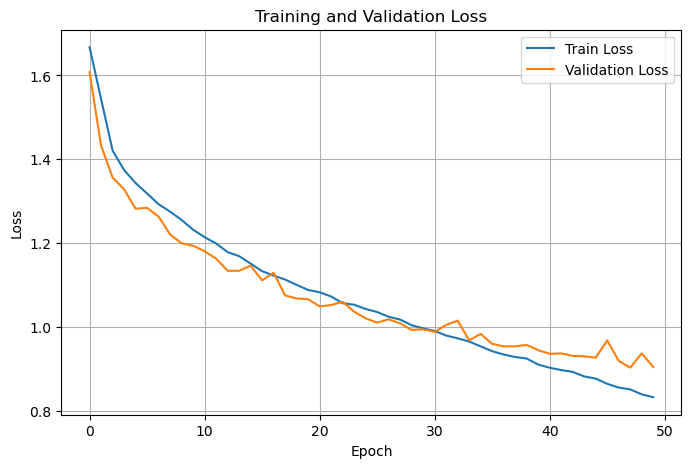

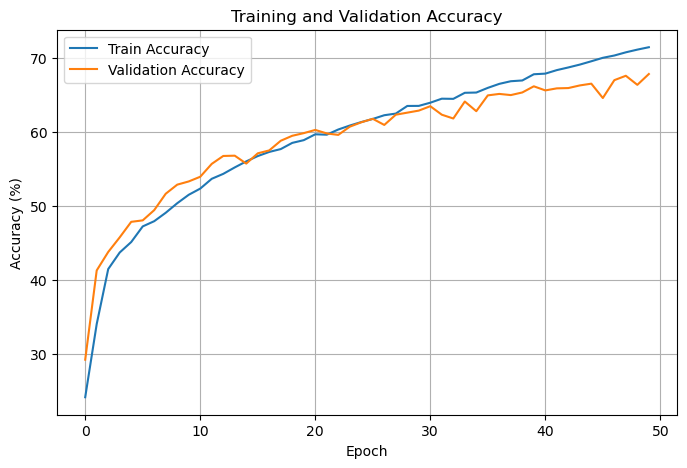

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pre_prune_weights = copy.deepcopy(model.state_dict())
# torch.save(model.state_dict(), f'pre_prune_{reg_weight}.pt', _use_new_zipfile_serialization=False)
training_checkpoint = {
    'epoch': num_epochs,  # or current epoch number if mid-training
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}

torch.save(training_checkpoint, f'pre_prune_checkpoint_{reg_weight}.pt', _use_new_zipfile_serialization=False)

In [436]:
model.load_state_dict(pre_prune_weights)

<All keys matched successfully>

In [435]:
1-0.1**(1/2)

0.683772233983162

In [437]:
pruning_ratio = 0.68#1-0.5**(1/2)
masks = prune_and_freeze(layers, G, pruning_ratio=pruning_ratio)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001, weight_decay=1e-2)

Pruning applied. Gradients for pruned weights are now frozen.


In [438]:
zero_count = 0
total_count = 0
for k, v in model.state_dict().items():
    if torch.is_tensor(v):
        zeros = (v == 0).sum().item()
        total = v.numel()
        zero_count += zeros
        total_count += total
        print(f"{k}: {zeros} out of {total} weights are zero ({100*zeros/total:.2f}%)")

print(f"\nTotal: {zero_count} out of {total_count} weights are zero ({100*zero_count/total_count:.2f}%)")

model.0.weight: 594 out of 864 weights are zero (68.75%)
model.0.bias: 22 out of 32 weights are zero (68.75%)
model.2.weight: 8316 out of 9216 weights are zero (90.23%)
model.2.bias: 22 out of 32 weights are zero (68.75%)
model.6.weight: 16632 out of 18432 weights are zero (90.23%)
model.6.bias: 44 out of 64 weights are zero (68.75%)
model.8.weight: 33264 out of 36864 weights are zero (90.23%)
model.8.bias: 44 out of 64 weights are zero (68.75%)
model.13.weight: 472128 out of 524288 weights are zero (90.05%)
model.13.bias: 349 out of 512 weights are zero (68.16%)
model.16.weight: 1745 out of 2560 weights are zero (68.16%)
model.16.bias: 0 out of 5 weights are zero (0.00%)

Total: 533160 out of 592933 weights are zero (89.92%)


In [439]:
print(validate(model, val_loader, criterion, device, 0))

(1.6116157951234262, 19.207920792079207)


In [ ]:
# Finetune training loop
num_epochs = 200

finetune_train_losses = []
finetune_train_accuracies = []
finetune_val_losses = []
finetune_val_accuracies = []

# Learning rate reduction parameters
lr_reduction_factor = 0.9  # Reduce LR by this when loss increases
min_lr = 1e-7 
patience = 100  # Number of consecutive increases before reducing LR
best_train_loss = float('inf')
loss_increase_count = 0

# Early stopping state
best_val_loss = float('inf')
best_val_accuracy = 0.0
best_state_dict = None
epochs_no_improve = 0
best_epoch = -1
stop_patience = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device, 0, masks=masks, zero_optimizer_state_fn=zero_optimizer_state_for_pruned_weights)

    val_loss, val_accuracy = validate(model, val_loader, criterion, device, 0)

    finetune_train_losses.append(train_loss)
    finetune_train_accuracies.append(train_accuracy)
    finetune_val_losses.append(val_loss)
    finetune_val_accuracies.append(val_accuracy)
    
    # Learning rate reduction logic: reduce LR if training loss increases
    if train_loss > best_train_loss:
        loss_increase_count += 1
        if loss_increase_count >= patience:
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = max(current_lr * lr_reduction_factor, min_lr)
            
            if new_lr < current_lr:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr
                # print(f'Training loss increased! Reducing learning rate: {current_lr:.2e} -> {new_lr:.2e}')
                loss_increase_count = 0  # Reset counter after reducing LR
    else:
        # Loss improved or stayed same, reset counter and update best loss
        loss_increase_count = 0
    best_train_loss = train_loss #Treat best as prev

    # Print epoch results
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
          f'LR: {current_lr:.2e}')


    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        best_epoch = epoch
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement (epoch {epoch+1})")
        # Revert model to best state dict
        if best_state_dict is not None:
            model.load_state_dict(best_state_dict)
            print(f"Model reverted to epoch {best_epoch+1} with best val loss: {best_val_loss:.4f} "
                  f"and val accuracy: {best_val_accuracy:.2f}%")
        break

Epoch 1/200


Epoch [1/200], Train Loss: 1.6101, Train Acc: 20.89%, Val Loss: 1.6110, Val Acc: 19.21%, LR: 1.00e-06
Epoch 2/200


Epoch [2/200], Train Loss: 1.6095, Train Acc: 21.29%, Val Loss: 1.6103, Val Acc: 19.21%, LR: 1.00e-06
Epoch 3/200


Epoch [3/200], Train Loss: 1.6088, Train Acc: 21.21%, Val Loss: 1.6096, Val Acc: 19.21%, LR: 1.00e-06
Epoch 4/200


Epoch [4/200], Train Loss: 1.6084, Train Acc: 20.89%, Val Loss: 1.6088, Val Acc: 19.21%, LR: 1.00e-06
Epoch 5/200


Epoch [5/200], Train Loss: 1.6076, Train Acc: 21.32%, Val Loss: 1.6080, Val Acc: 19.21%, LR: 1.00e-06
Epoch 6/200


KeyboardInterrupt: 

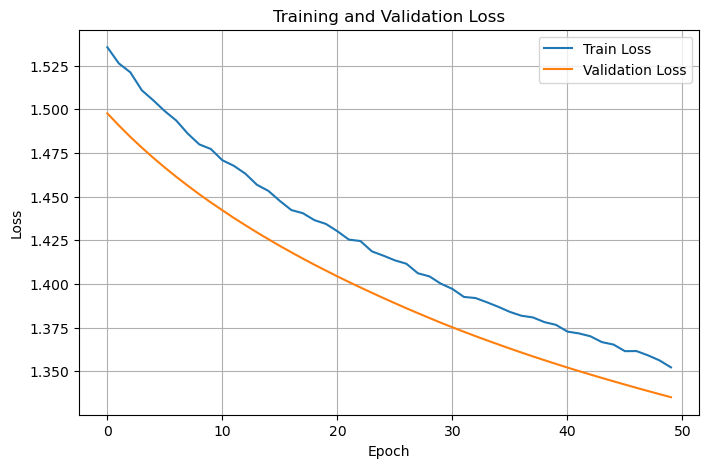

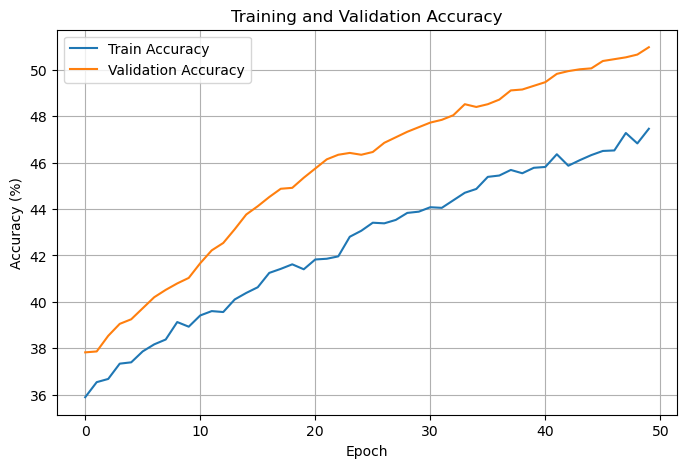

In [410]:
plt.figure(figsize=(8,5))
plt.plot(finetune_train_losses, label='Train Loss')
plt.plot(finetune_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
plt.plot(finetune_train_accuracies, label='Train Accuracy')
plt.plot(finetune_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [411]:
pruned_weights = copy.deepcopy(model.state_dict())
# torch.save(model.state_dict(), f'pre_prune_{reg_weight}.pt', _use_new_zipfile_serialization=False)
training_checkpoint = {
    'epoch': num_epochs,  # or current epoch number if mid-training
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': finetune_train_losses,
    'train_accuracies': finetune_train_accuracies,
    'val_losses': finetune_val_losses,
    'val_accuracies': finetune_val_accuracies,
}

torch.save(training_checkpoint, f'pruned_checkpoint_{reg_weight}_{pruning_ratio}.pt', _use_new_zipfile_serialization=False)

### Full Grid Search

In [ ]:
for reg_weight in [1e-3, 1e-4, 1e-5]:
    print(f"-------------------- {reg_weight} --------------------")
    model = ConvNet()
    layers = [i for i in next(model.children()).children()]
    G_og = get_dep_graph(layers)
    G = {g for g in G_og if 0 not in g and len(layers)*2-1 not in g}

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=5, cooldown=2, min_lr=1e-6)
    model = model.to(device)


    # Main training loop with early stopping based on validation loss
    num_epochs = 200
    patience = 10 

    # Track metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Early stopping state
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_state_dict = None
    epochs_no_improve = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device, reg_weight)

        # Validation
        val_loss, val_accuracy = validate(model, val_loader, criterion, device, reg_weight)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early Stopping
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            best_state_dict = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            best_epoch = epoch
        else:
            epochs_no_improve += 1

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement (epoch {epoch+1})")
            # Revert model to best state dict
            if best_state_dict is not None:
                model.load_state_dict(best_state_dict)
                print(f"Model reverted to epoch {best_epoch+1} with best val loss: {best_val_loss:.4f} "
                    f"and val accuracy: {best_val_accuracy:.2f}%")
            break



    pre_prune_weights = copy.deepcopy(model.state_dict())
    # torch.save(model.state_dict(), f'pre_prune_{reg_weight}.pt', _use_new_zipfile_serialization=False)
    training_checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
    }

    torch.save(training_checkpoint, f'pre_prune_checkpoint_{reg_weight}.pt', _use_new_zipfile_serialization=False)

    

    for pruning_ratio in [round(1-(1-i)**(1/2),2) for i in [0.5, 0.6, 0.7, 0.8, 0.9]]:
        print(f"-------------------- {reg_weight, pruning_ratio} --------------------")
        masks = prune_and_freeze(layers, G, pruning_ratio=pruning_ratio)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, cooldown=2, min_lr=5e-8)

        zero_count = 0
        total_count = 0
        for k, v in model.state_dict().items():
            if torch.is_tensor(v):
                zeros = (v == 0).sum().item()
                total = v.numel()
                zero_count += zeros
                total_count += total
                print(f"{k}: {zeros} out of {total} weights are zero ({100*zeros/total:.2f}%)")

        print(f"\nTotal: {zero_count} out of {total_count} weights are zero ({100*zero_count/total_count:.2f}%)")




        # Finetune training loop
        num_epochs = 200

        finetune_train_losses = []
        finetune_train_accuracies = []
        finetune_val_losses = []
        finetune_val_accuracies = []

        # Early stopping state
        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        best_state_dict = None
        epochs_no_improve = 0
        best_epoch = -1
        patience = 10

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            # Training - pass masks to ensure pruned weights stay at zero
            train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device, 0, masks=masks, zero_optimizer_state_fn=zero_optimizer_state_for_pruned_weights)

            # Validation
            val_loss, val_accuracy = validate(model, val_loader, criterion, device, 0)

            finetune_train_losses.append(train_loss)
            finetune_train_accuracies.append(train_accuracy)
            finetune_val_losses.append(val_loss)
            finetune_val_accuracies.append(val_accuracy)
            


            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
                f'LR: {current_lr:.2e}')


            # Early Stopping
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_accuracy = val_accuracy
                best_state_dict = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_epoch = epoch
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement (epoch {epoch+1})")
                # Revert model to best state dict
                if best_state_dict is not None:
                    model.load_state_dict(best_state_dict)
                    print(f"Model reverted to epoch {best_epoch+1} with best val loss: {best_val_loss:.4f} "
                        f"and val accuracy: {best_val_accuracy:.2f}%")
                break

        


        pruned_weights = copy.deepcopy(model.state_dict())
        training_checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': finetune_train_losses,
            'train_accuracies': finetune_train_accuracies,
            'val_losses': finetune_val_losses,
            'val_accuracies': finetune_val_accuracies,
        }

        torch.save(training_checkpoint, f'pruned_checkpoint_{reg_weight}_{pruning_ratio}.pt', _use_new_zipfile_serialization=False)

        if best_val_accuracy < 0.58:
            print(f"Stopped at pruning_ratio = {pruning_ratio}, skipping...")
            break

-------------------- 0.001 --------------------
Epoch 1/200


Epoch [1/200], Train Loss: 2.4472, Train Acc: 27.71%, Val Loss: 2.0234, Val Acc: 38.50%
Epoch 2/200


Epoch [2/200], Train Loss: 1.9276, Train Acc: 39.94%, Val Loss: 1.7461, Val Acc: 43.13%
Epoch 3/200


Epoch [3/200], Train Loss: 1.6559, Train Acc: 42.62%, Val Loss: 1.5443, Val Acc: 43.96%
Epoch 4/200


Epoch [4/200], Train Loss: 1.5184, Train Acc: 44.19%, Val Loss: 1.4859, Val Acc: 44.51%
Epoch 5/200


Epoch [5/200], Train Loss: 1.4662, Train Acc: 45.35%, Val Loss: 1.3976, Val Acc: 48.36%
Epoch 6/200


Epoch [6/200], Train Loss: 1.4352, Train Acc: 47.07%, Val Loss: 1.3995, Val Acc: 49.35%
Epoch 7/200


Epoch [7/200], Train Loss: 1.4117, Train Acc: 49.34%, Val Loss: 1.3651, Val Acc: 52.55%
Epoch 8/200


Epoch [8/200], Train Loss: 1.3935, Train Acc: 50.54%, Val Loss: 1.3347, Val Acc: 52.55%
Epoch 9/200


Epoch [9/200], Train Loss: 1.3716, Train Acc: 52.21%, Val Loss: 1.3008, Val Acc: 55.88%
Epoch 10/200


Epoch [10/200], Train Loss: 1.3572, Train Acc: 53.33%, Val Loss: 1.2795, Val Acc: 57.74%
Epoch 11/200


Epoch [11/200], Train Loss: 1.3368, Train Acc: 54.93%, Val Loss: 1.3020, Val Acc: 55.84%
Epoch 12/200


Epoch [12/200], Train Loss: 1.3216, Train Acc: 56.25%, Val Loss: 1.2590, Val Acc: 59.56%
Epoch 13/200


Epoch [13/200], Train Loss: 1.3070, Train Acc: 57.36%, Val Loss: 1.2445, Val Acc: 59.21%
Epoch 14/200


Epoch [14/200], Train Loss: 1.2977, Train Acc: 58.11%, Val Loss: 1.2340, Val Acc: 60.63%
Epoch 15/200


Epoch [15/200], Train Loss: 1.2788, Train Acc: 58.81%, Val Loss: 1.2806, Val Acc: 58.10%
Epoch 16/200


Epoch [16/200], Train Loss: 1.2763, Train Acc: 59.69%, Val Loss: 1.2321, Val Acc: 59.60%
Epoch 17/200


Epoch [17/200], Train Loss: 1.2709, Train Acc: 59.98%, Val Loss: 1.2370, Val Acc: 60.99%
Epoch 18/200


Epoch [18/200], Train Loss: 1.2622, Train Acc: 60.66%, Val Loss: 1.1817, Val Acc: 63.72%
Epoch 19/200


Epoch [19/200], Train Loss: 1.2489, Train Acc: 61.54%, Val Loss: 1.2117, Val Acc: 60.95%
Epoch 20/200


Epoch [20/200], Train Loss: 1.2421, Train Acc: 61.71%, Val Loss: 1.1884, Val Acc: 63.37%
Epoch 21/200


Epoch [21/200], Train Loss: 1.2406, Train Acc: 62.45%, Val Loss: 1.1749, Val Acc: 64.75%
Epoch 22/200


Epoch [22/200], Train Loss: 1.2333, Train Acc: 62.67%, Val Loss: 1.2092, Val Acc: 62.50%
Epoch 23/200


Epoch [23/200], Train Loss: 1.2231, Train Acc: 63.46%, Val Loss: 1.1714, Val Acc: 65.15%
Epoch 24/200


Epoch [24/200], Train Loss: 1.2210, Train Acc: 63.81%, Val Loss: 1.2232, Val Acc: 62.57%
Epoch 25/200


Epoch [25/200], Train Loss: 1.2155, Train Acc: 64.06%, Val Loss: 1.1529, Val Acc: 66.89%
Epoch 26/200


Epoch [26/200], Train Loss: 1.2117, Train Acc: 64.70%, Val Loss: 1.1651, Val Acc: 66.57%
Epoch 27/200


Epoch [27/200], Train Loss: 1.2022, Train Acc: 65.09%, Val Loss: 1.2080, Val Acc: 65.31%
Epoch 28/200


Epoch [28/200], Train Loss: 1.2036, Train Acc: 65.16%, Val Loss: 1.1683, Val Acc: 65.86%
Epoch 29/200


Epoch [29/200], Train Loss: 1.1951, Train Acc: 65.93%, Val Loss: 1.1358, Val Acc: 68.24%
Epoch 30/200


Epoch [30/200], Train Loss: 1.1886, Train Acc: 65.97%, Val Loss: 1.2063, Val Acc: 64.99%
Epoch 31/200


Epoch [31/200], Train Loss: 1.1817, Train Acc: 66.68%, Val Loss: 1.1829, Val Acc: 66.26%
Epoch 32/200


Epoch [32/200], Train Loss: 1.1849, Train Acc: 66.34%, Val Loss: 1.1409, Val Acc: 68.20%
Epoch 33/200


Epoch [33/200], Train Loss: 1.1801, Train Acc: 66.90%, Val Loss: 1.1558, Val Acc: 67.45%
Epoch 34/200


Epoch [34/200], Train Loss: 1.1799, Train Acc: 67.01%, Val Loss: 1.1842, Val Acc: 65.94%
Epoch 35/200


Epoch [35/200], Train Loss: 1.1681, Train Acc: 67.88%, Val Loss: 1.1387, Val Acc: 68.08%
Epoch 36/200


Epoch [36/200], Train Loss: 1.0456, Train Acc: 70.03%, Val Loss: 1.0130, Val Acc: 70.34%
Epoch 37/200


Epoch [37/200], Train Loss: 1.0112, Train Acc: 70.85%, Val Loss: 0.9990, Val Acc: 70.81%
Epoch 38/200


Epoch [38/200], Train Loss: 1.0017, Train Acc: 71.20%, Val Loss: 0.9879, Val Acc: 71.68%
Epoch 39/200


Epoch [39/200], Train Loss: 1.0015, Train Acc: 71.23%, Val Loss: 0.9903, Val Acc: 71.60%
Epoch 40/200


Epoch [40/200], Train Loss: 0.9940, Train Acc: 71.23%, Val Loss: 0.9998, Val Acc: 70.50%
Epoch 41/200


Epoch [41/200], Train Loss: 0.9866, Train Acc: 71.50%, Val Loss: 0.9866, Val Acc: 71.41%
Epoch 42/200


Epoch [42/200], Train Loss: 0.9900, Train Acc: 71.26%, Val Loss: 0.9880, Val Acc: 71.13%
Epoch 43/200


Epoch [43/200], Train Loss: 0.9841, Train Acc: 71.54%, Val Loss: 0.9806, Val Acc: 71.84%
Epoch 44/200


Epoch [44/200], Train Loss: 0.9769, Train Acc: 72.34%, Val Loss: 1.0409, Val Acc: 68.48%
Epoch 45/200


Epoch [45/200], Train Loss: 0.9757, Train Acc: 71.72%, Val Loss: 0.9799, Val Acc: 71.45%
Epoch 46/200


Epoch [46/200], Train Loss: 0.9732, Train Acc: 72.13%, Val Loss: 0.9805, Val Acc: 72.24%
Epoch 47/200


Epoch [47/200], Train Loss: 0.9736, Train Acc: 72.22%, Val Loss: 0.9689, Val Acc: 72.08%
Epoch 48/200


Epoch [48/200], Train Loss: 0.9719, Train Acc: 72.32%, Val Loss: 0.9731, Val Acc: 72.12%
Epoch 49/200


Epoch [49/200], Train Loss: 0.9710, Train Acc: 72.72%, Val Loss: 1.0055, Val Acc: 70.89%
Epoch 50/200


Epoch [50/200], Train Loss: 0.9707, Train Acc: 72.20%, Val Loss: 0.9718, Val Acc: 71.80%
Epoch 51/200


Epoch [51/200], Train Loss: 0.9718, Train Acc: 72.48%, Val Loss: 0.9647, Val Acc: 73.11%
Epoch 52/200


Epoch [52/200], Train Loss: 0.9705, Train Acc: 72.51%, Val Loss: 0.9739, Val Acc: 72.12%
Epoch 53/200


Epoch [53/200], Train Loss: 0.9601, Train Acc: 73.29%, Val Loss: 0.9779, Val Acc: 72.12%
Epoch 54/200


Epoch [54/200], Train Loss: 0.9600, Train Acc: 72.95%, Val Loss: 0.9735, Val Acc: 72.48%
Epoch 55/200


Epoch [55/200], Train Loss: 0.9621, Train Acc: 73.10%, Val Loss: 0.9585, Val Acc: 72.55%
Epoch 56/200


Epoch [56/200], Train Loss: 0.9549, Train Acc: 73.16%, Val Loss: 0.9701, Val Acc: 72.12%
Epoch 57/200


Epoch [57/200], Train Loss: 0.9549, Train Acc: 73.20%, Val Loss: 0.9893, Val Acc: 71.68%
Epoch 58/200


Epoch [58/200], Train Loss: 0.9499, Train Acc: 73.45%, Val Loss: 0.9963, Val Acc: 71.56%
Epoch 59/200


Epoch [59/200], Train Loss: 0.9515, Train Acc: 73.75%, Val Loss: 0.9657, Val Acc: 72.51%
Epoch 60/200


Epoch [60/200], Train Loss: 0.9523, Train Acc: 73.88%, Val Loss: 0.9773, Val Acc: 72.28%
Epoch 61/200


Epoch [61/200], Train Loss: 0.9476, Train Acc: 73.99%, Val Loss: 0.9786, Val Acc: 71.96%
Epoch 62/200


Epoch [62/200], Train Loss: 0.9148, Train Acc: 74.80%, Val Loss: 0.9378, Val Acc: 74.10%
Epoch 63/200


Epoch [63/200], Train Loss: 0.9073, Train Acc: 75.04%, Val Loss: 0.9403, Val Acc: 73.70%
Epoch 64/200


Epoch [64/200], Train Loss: 0.9047, Train Acc: 74.84%, Val Loss: 0.9440, Val Acc: 73.39%
Epoch 65/200


Epoch [65/200], Train Loss: 0.9043, Train Acc: 75.23%, Val Loss: 0.9364, Val Acc: 73.86%
Epoch 66/200


Epoch [66/200], Train Loss: 0.9018, Train Acc: 75.26%, Val Loss: 0.9347, Val Acc: 73.82%
Epoch 67/200


Epoch [67/200], Train Loss: 0.8966, Train Acc: 75.31%, Val Loss: 0.9429, Val Acc: 73.66%
Epoch 68/200


Epoch [68/200], Train Loss: 0.8961, Train Acc: 75.31%, Val Loss: 0.9291, Val Acc: 73.66%
Epoch 69/200


Epoch [69/200], Train Loss: 0.8923, Train Acc: 75.61%, Val Loss: 0.9365, Val Acc: 73.23%
Epoch 70/200


Epoch [70/200], Train Loss: 0.8936, Train Acc: 75.41%, Val Loss: 0.9418, Val Acc: 73.15%
Epoch 71/200


Epoch [71/200], Train Loss: 0.8953, Train Acc: 75.42%, Val Loss: 0.9300, Val Acc: 73.74%
Epoch 72/200


Epoch [72/200], Train Loss: 0.8926, Train Acc: 75.42%, Val Loss: 0.9372, Val Acc: 73.47%
Epoch 73/200


Epoch [73/200], Train Loss: 0.8898, Train Acc: 75.74%, Val Loss: 0.9384, Val Acc: 73.58%
Epoch 74/200


Epoch [74/200], Train Loss: 0.8919, Train Acc: 75.46%, Val Loss: 0.9365, Val Acc: 73.39%
Epoch 75/200


Epoch [75/200], Train Loss: 0.8797, Train Acc: 76.11%, Val Loss: 0.9314, Val Acc: 73.70%
Epoch 76/200


Epoch [76/200], Train Loss: 0.8791, Train Acc: 76.08%, Val Loss: 0.9302, Val Acc: 73.66%
Epoch 77/200


Epoch [77/200], Train Loss: 0.8827, Train Acc: 75.96%, Val Loss: 0.9329, Val Acc: 73.66%
Epoch 78/200


Epoch [78/200], Train Loss: 0.8807, Train Acc: 75.89%, Val Loss: 0.9284, Val Acc: 73.70%
Epoch 79/200


Epoch [79/200], Train Loss: 0.8774, Train Acc: 76.28%, Val Loss: 0.9349, Val Acc: 73.66%
Epoch 80/200


Epoch [80/200], Train Loss: 0.8782, Train Acc: 76.17%, Val Loss: 0.9339, Val Acc: 73.94%
Epoch 81/200


Epoch [81/200], Train Loss: 0.8748, Train Acc: 76.00%, Val Loss: 0.9278, Val Acc: 73.31%
Epoch 82/200


Epoch [82/200], Train Loss: 0.8780, Train Acc: 76.03%, Val Loss: 0.9300, Val Acc: 73.35%
Epoch 83/200


Epoch [83/200], Train Loss: 0.8784, Train Acc: 75.61%, Val Loss: 0.9250, Val Acc: 73.43%
Epoch 84/200


Epoch [84/200], Train Loss: 0.8781, Train Acc: 76.00%, Val Loss: 0.9308, Val Acc: 73.74%
Epoch 85/200


Epoch [85/200], Train Loss: 0.8790, Train Acc: 75.91%, Val Loss: 0.9238, Val Acc: 73.62%
Epoch 86/200


Epoch [86/200], Train Loss: 0.8791, Train Acc: 75.97%, Val Loss: 0.9287, Val Acc: 73.86%
Epoch 87/200


Epoch [87/200], Train Loss: 0.8806, Train Acc: 75.67%, Val Loss: 0.9306, Val Acc: 73.78%
Epoch 88/200


Epoch [88/200], Train Loss: 0.8694, Train Acc: 76.32%, Val Loss: 0.9292, Val Acc: 73.82%
Epoch 89/200


Epoch [89/200], Train Loss: 0.8762, Train Acc: 76.09%, Val Loss: 0.9354, Val Acc: 73.54%
Epoch 90/200


Epoch [90/200], Train Loss: 0.8763, Train Acc: 76.35%, Val Loss: 0.9335, Val Acc: 73.54%
Epoch 91/200


Epoch [91/200], Train Loss: 0.8776, Train Acc: 75.94%, Val Loss: 0.9354, Val Acc: 73.90%
Epoch 92/200


Epoch [92/200], Train Loss: 0.8727, Train Acc: 76.22%, Val Loss: 0.9297, Val Acc: 73.98%
Epoch 93/200


Epoch [93/200], Train Loss: 0.8721, Train Acc: 76.36%, Val Loss: 0.9270, Val Acc: 74.02%
Epoch 94/200


Epoch [94/200], Train Loss: 0.8729, Train Acc: 76.06%, Val Loss: 0.9281, Val Acc: 73.74%
Epoch 95/200


Epoch [95/200], Train Loss: 0.8738, Train Acc: 76.14%, Val Loss: 0.9263, Val Acc: 73.90%
Early stopping triggered after 10 epochs without improvement (epoch 95)
Model reverted to epoch 85 with best val loss: 0.9238 and val accuracy: 73.62%
-------------------- (0.001, 0.29) --------------------
Pruning applied. Gradients for pruned weights are now frozen.
model.0.weight: 270 out of 864 weights are zero (31.25%)
model.0.bias: 10 out of 32 weights are zero (31.25%)
model.2.weight: 4860 out of 9216 weights are zero (52.73%)
model.2.bias: 10 out of 32 weights are zero (31.25%)
model.6.weight: 9522 out of 18432 weights are zero (51.66%)
model.6.bias: 19 out of 64 weights are zero (29.69%)
model.8.weight: 18639 out of 36864 weights are zero (50.56%)
model.8.bias: 19 out of 64 weights are zero (29.69%)
model.13.weight: 262928 out of 524288 weights are zero (50.15%)
model.13.bias: 149 out of 512 weights are zero (29.10%)
model.16.weight: 745 out of 2560 weights are zero (29.10%)
model.16.bias:

Epoch [1/200], Train Loss: 2.1666, Train Acc: 27.80%, Val Loss: 1.6236, Val Acc: 36.44%, LR: 1.00e-06
Epoch 2/200


Epoch [2/200], Train Loss: 1.5202, Train Acc: 38.40%, Val Loss: 1.3384, Val Acc: 46.38%, LR: 1.00e-06
Epoch 3/200


Epoch [3/200], Train Loss: 1.3396, Train Acc: 45.35%, Val Loss: 1.2454, Val Acc: 51.21%, LR: 1.00e-06
Epoch 4/200


Epoch [4/200], Train Loss: 1.2604, Train Acc: 49.27%, Val Loss: 1.1821, Val Acc: 53.54%, LR: 1.00e-06
Epoch 5/200


Epoch [5/200], Train Loss: 1.2025, Train Acc: 51.84%, Val Loss: 1.1300, Val Acc: 56.08%, LR: 1.00e-06
Epoch 6/200


Epoch [6/200], Train Loss: 1.1602, Train Acc: 54.18%, Val Loss: 1.0941, Val Acc: 57.98%, LR: 1.00e-06
Epoch 7/200


Epoch [7/200], Train Loss: 1.1260, Train Acc: 56.06%, Val Loss: 1.0637, Val Acc: 59.96%, LR: 1.00e-06
Epoch 8/200


Epoch [8/200], Train Loss: 1.1005, Train Acc: 57.45%, Val Loss: 1.0425, Val Acc: 61.27%, LR: 1.00e-06
Epoch 9/200


Epoch [9/200], Train Loss: 1.0821, Train Acc: 58.18%, Val Loss: 1.0255, Val Acc: 61.82%, LR: 1.00e-06
Epoch 10/200


Epoch [10/200], Train Loss: 1.0635, Train Acc: 59.43%, Val Loss: 1.0124, Val Acc: 62.42%, LR: 1.00e-06
Epoch 11/200


Epoch [11/200], Train Loss: 1.0518, Train Acc: 59.98%, Val Loss: 1.0002, Val Acc: 63.25%, LR: 1.00e-06
Epoch 12/200


Epoch [12/200], Train Loss: 1.0421, Train Acc: 60.30%, Val Loss: 0.9920, Val Acc: 63.60%, LR: 1.00e-06
Epoch 13/200


Epoch [13/200], Train Loss: 1.0274, Train Acc: 61.07%, Val Loss: 0.9858, Val Acc: 63.80%, LR: 1.00e-06
Epoch 14/200


Epoch [14/200], Train Loss: 1.0221, Train Acc: 61.25%, Val Loss: 0.9759, Val Acc: 64.32%, LR: 1.00e-06
Epoch 15/200


Epoch [15/200], Train Loss: 1.0160, Train Acc: 61.64%, Val Loss: 0.9706, Val Acc: 64.44%, LR: 1.00e-06
Epoch 16/200


Epoch [16/200], Train Loss: 1.0115, Train Acc: 61.46%, Val Loss: 0.9639, Val Acc: 64.48%, LR: 1.00e-06
Epoch 17/200


Epoch [17/200], Train Loss: 1.0065, Train Acc: 61.96%, Val Loss: 0.9587, Val Acc: 64.71%, LR: 1.00e-06
Epoch 18/200


Epoch [18/200], Train Loss: 0.9979, Train Acc: 61.92%, Val Loss: 0.9531, Val Acc: 64.95%, LR: 1.00e-06
Epoch 19/200


Epoch [19/200], Train Loss: 0.9942, Train Acc: 62.23%, Val Loss: 0.9509, Val Acc: 64.91%, LR: 1.00e-06
Epoch 20/200


Epoch [20/200], Train Loss: 0.9878, Train Acc: 62.45%, Val Loss: 0.9456, Val Acc: 64.95%, LR: 1.00e-06
Epoch 21/200


Epoch [21/200], Train Loss: 0.9836, Train Acc: 62.88%, Val Loss: 0.9421, Val Acc: 65.03%, LR: 1.00e-06
Epoch 22/200


Epoch [22/200], Train Loss: 0.9824, Train Acc: 62.92%, Val Loss: 0.9395, Val Acc: 65.23%, LR: 1.00e-06
Epoch 23/200


Epoch [23/200], Train Loss: 0.9736, Train Acc: 62.97%, Val Loss: 0.9350, Val Acc: 65.03%, LR: 1.00e-06
Epoch 24/200


Epoch [24/200], Train Loss: 0.9697, Train Acc: 63.19%, Val Loss: 0.9337, Val Acc: 64.87%, LR: 1.00e-06
Epoch 25/200


Epoch [25/200], Train Loss: 0.9661, Train Acc: 63.56%, Val Loss: 0.9298, Val Acc: 65.27%, LR: 1.00e-06
Epoch 26/200


Epoch [26/200], Train Loss: 0.9676, Train Acc: 63.45%, Val Loss: 0.9249, Val Acc: 65.35%, LR: 1.00e-06
Epoch 27/200


Epoch [27/200], Train Loss: 0.9603, Train Acc: 63.65%, Val Loss: 0.9247, Val Acc: 65.31%, LR: 1.00e-06
Epoch 28/200


Epoch [28/200], Train Loss: 0.9585, Train Acc: 63.78%, Val Loss: 0.9205, Val Acc: 65.31%, LR: 1.00e-06
Epoch 29/200


Epoch [29/200], Train Loss: 0.9528, Train Acc: 63.97%, Val Loss: 0.9182, Val Acc: 65.62%, LR: 1.00e-06
Epoch 30/200


Epoch [30/200], Train Loss: 0.9521, Train Acc: 63.81%, Val Loss: 0.9150, Val Acc: 65.54%, LR: 1.00e-06
Epoch 31/200


Epoch [31/200], Train Loss: 0.9481, Train Acc: 63.99%, Val Loss: 0.9138, Val Acc: 65.66%, LR: 1.00e-06
Epoch 32/200


Epoch [32/200], Train Loss: 0.9505, Train Acc: 63.79%, Val Loss: 0.9110, Val Acc: 65.94%, LR: 1.00e-06
Epoch 33/200


Epoch [33/200], Train Loss: 0.9467, Train Acc: 64.12%, Val Loss: 0.9083, Val Acc: 65.78%, LR: 1.00e-06
Epoch 34/200


Epoch [34/200], Train Loss: 0.9444, Train Acc: 64.02%, Val Loss: 0.9064, Val Acc: 66.06%, LR: 1.00e-06
Epoch 35/200


Epoch [35/200], Train Loss: 0.9392, Train Acc: 64.37%, Val Loss: 0.9041, Val Acc: 66.10%, LR: 1.00e-06
Epoch 36/200


Epoch [36/200], Train Loss: 0.9342, Train Acc: 64.77%, Val Loss: 0.9034, Val Acc: 66.06%, LR: 1.00e-06
Epoch 37/200


Epoch [37/200], Train Loss: 0.9400, Train Acc: 64.20%, Val Loss: 0.9002, Val Acc: 66.18%, LR: 1.00e-06
Epoch 38/200


Epoch [38/200], Train Loss: 0.9335, Train Acc: 64.71%, Val Loss: 0.8972, Val Acc: 66.14%, LR: 1.00e-06
Epoch 39/200


Epoch [39/200], Train Loss: 0.9308, Train Acc: 64.41%, Val Loss: 0.8960, Val Acc: 66.26%, LR: 1.00e-06
Epoch 40/200


Epoch [40/200], Train Loss: 0.9305, Train Acc: 64.83%, Val Loss: 0.8950, Val Acc: 66.42%, LR: 1.00e-06
Epoch 41/200


Epoch [41/200], Train Loss: 0.9314, Train Acc: 64.69%, Val Loss: 0.8926, Val Acc: 66.42%, LR: 1.00e-06
Epoch 42/200


Epoch [42/200], Train Loss: 0.9250, Train Acc: 65.25%, Val Loss: 0.8933, Val Acc: 66.22%, LR: 1.00e-06
Epoch 43/200


Epoch [43/200], Train Loss: 0.9255, Train Acc: 64.68%, Val Loss: 0.8901, Val Acc: 66.42%, LR: 1.00e-06
Epoch 44/200


Epoch [44/200], Train Loss: 0.9226, Train Acc: 65.08%, Val Loss: 0.8886, Val Acc: 66.50%, LR: 1.00e-06
Epoch 45/200


Epoch [45/200], Train Loss: 0.9237, Train Acc: 65.22%, Val Loss: 0.8877, Val Acc: 66.46%, LR: 1.00e-06
Epoch 46/200


Epoch [46/200], Train Loss: 0.9183, Train Acc: 65.08%, Val Loss: 0.8863, Val Acc: 66.26%, LR: 1.00e-06
Epoch 47/200


Epoch [47/200], Train Loss: 0.9229, Train Acc: 65.08%, Val Loss: 0.8847, Val Acc: 66.53%, LR: 1.00e-06
Epoch 48/200


Epoch [48/200], Train Loss: 0.9165, Train Acc: 65.25%, Val Loss: 0.8839, Val Acc: 66.42%, LR: 1.00e-06
Epoch 49/200


Epoch [49/200], Train Loss: 0.9170, Train Acc: 64.99%, Val Loss: 0.8811, Val Acc: 66.42%, LR: 1.00e-06
Epoch 50/200


Epoch [50/200], Train Loss: 0.9136, Train Acc: 65.31%, Val Loss: 0.8796, Val Acc: 66.61%, LR: 1.00e-06
Epoch 51/200


Epoch [51/200], Train Loss: 0.9154, Train Acc: 65.51%, Val Loss: 0.8769, Val Acc: 66.46%, LR: 1.00e-06
Epoch 52/200


Epoch [52/200], Train Loss: 0.9068, Train Acc: 65.88%, Val Loss: 0.8769, Val Acc: 66.61%, LR: 1.00e-06
Epoch 53/200


Epoch [53/200], Train Loss: 0.9078, Train Acc: 65.68%, Val Loss: 0.8767, Val Acc: 66.30%, LR: 1.00e-06
Epoch 54/200


Epoch [54/200], Train Loss: 0.9094, Train Acc: 65.50%, Val Loss: 0.8724, Val Acc: 67.09%, LR: 1.00e-06
Epoch 55/200


Epoch [55/200], Train Loss: 0.9036, Train Acc: 65.42%, Val Loss: 0.8734, Val Acc: 66.61%, LR: 1.00e-06
Epoch 56/200


Epoch [56/200], Train Loss: 0.9062, Train Acc: 65.62%, Val Loss: 0.8720, Val Acc: 66.97%, LR: 1.00e-06
Epoch 57/200


Epoch [57/200], Train Loss: 0.9020, Train Acc: 66.28%, Val Loss: 0.8710, Val Acc: 66.77%, LR: 1.00e-06
Epoch 58/200


Epoch [58/200], Train Loss: 0.9057, Train Acc: 65.70%, Val Loss: 0.8682, Val Acc: 66.85%, LR: 1.00e-06
Epoch 59/200


Epoch [59/200], Train Loss: 0.9019, Train Acc: 65.61%, Val Loss: 0.8693, Val Acc: 66.77%, LR: 1.00e-06
Epoch 60/200


Epoch [60/200], Train Loss: 0.8986, Train Acc: 65.99%, Val Loss: 0.8672, Val Acc: 66.97%, LR: 1.00e-06
Epoch 61/200


Epoch [61/200], Train Loss: 0.9008, Train Acc: 65.78%, Val Loss: 0.8664, Val Acc: 67.21%, LR: 1.00e-06
Epoch 62/200


Epoch [62/200], Train Loss: 0.8961, Train Acc: 66.30%, Val Loss: 0.8647, Val Acc: 67.05%, LR: 1.00e-06
Epoch 63/200


Epoch [63/200], Train Loss: 0.9004, Train Acc: 65.98%, Val Loss: 0.8638, Val Acc: 67.29%, LR: 1.00e-06
Epoch 64/200


Epoch [64/200], Train Loss: 0.8947, Train Acc: 66.37%, Val Loss: 0.8641, Val Acc: 67.29%, LR: 1.00e-06
Epoch 65/200


Epoch [65/200], Train Loss: 0.8954, Train Acc: 65.99%, Val Loss: 0.8614, Val Acc: 67.25%, LR: 1.00e-06
Epoch 66/200


Epoch [66/200], Train Loss: 0.8921, Train Acc: 66.11%, Val Loss: 0.8606, Val Acc: 67.25%, LR: 1.00e-06
Epoch 67/200


Epoch [67/200], Train Loss: 0.8940, Train Acc: 65.93%, Val Loss: 0.8599, Val Acc: 67.33%, LR: 1.00e-06
Epoch 68/200


Epoch [68/200], Train Loss: 0.8893, Train Acc: 66.51%, Val Loss: 0.8590, Val Acc: 67.37%, LR: 1.00e-06
Epoch 69/200


Epoch [69/200], Train Loss: 0.8914, Train Acc: 66.42%, Val Loss: 0.8571, Val Acc: 67.33%, LR: 1.00e-06
Epoch 70/200


Epoch [70/200], Train Loss: 0.8898, Train Acc: 66.38%, Val Loss: 0.8562, Val Acc: 67.49%, LR: 1.00e-06
Epoch 71/200


Epoch [71/200], Train Loss: 0.8882, Train Acc: 66.12%, Val Loss: 0.8558, Val Acc: 67.60%, LR: 1.00e-06
Epoch 72/200


Epoch [72/200], Train Loss: 0.8877, Train Acc: 66.29%, Val Loss: 0.8548, Val Acc: 67.60%, LR: 1.00e-06
Epoch 73/200


Epoch [73/200], Train Loss: 0.8865, Train Acc: 66.43%, Val Loss: 0.8544, Val Acc: 67.64%, LR: 1.00e-06
Epoch 74/200


Epoch [74/200], Train Loss: 0.8847, Train Acc: 66.27%, Val Loss: 0.8536, Val Acc: 67.56%, LR: 1.00e-06
Epoch 75/200


Epoch [75/200], Train Loss: 0.8859, Train Acc: 66.74%, Val Loss: 0.8530, Val Acc: 67.72%, LR: 1.00e-06
Epoch 76/200


Epoch [76/200], Train Loss: 0.8834, Train Acc: 66.74%, Val Loss: 0.8538, Val Acc: 67.72%, LR: 1.00e-06
Epoch 77/200


Epoch [77/200], Train Loss: 0.8822, Train Acc: 66.42%, Val Loss: 0.8506, Val Acc: 67.72%, LR: 1.00e-06
Epoch 78/200


Epoch [78/200], Train Loss: 0.8778, Train Acc: 66.95%, Val Loss: 0.8520, Val Acc: 67.56%, LR: 1.00e-06
Epoch 79/200


Epoch [79/200], Train Loss: 0.8763, Train Acc: 67.13%, Val Loss: 0.8478, Val Acc: 67.72%, LR: 1.00e-06
Epoch 80/200


Epoch [80/200], Train Loss: 0.8849, Train Acc: 66.27%, Val Loss: 0.8484, Val Acc: 67.56%, LR: 1.00e-06
Epoch 81/200


Epoch [81/200], Train Loss: 0.8757, Train Acc: 66.98%, Val Loss: 0.8479, Val Acc: 67.56%, LR: 1.00e-06
Epoch 82/200


Epoch [82/200], Train Loss: 0.8742, Train Acc: 67.15%, Val Loss: 0.8466, Val Acc: 67.76%, LR: 1.00e-06
Epoch 83/200


Epoch [83/200], Train Loss: 0.8771, Train Acc: 66.66%, Val Loss: 0.8476, Val Acc: 67.72%, LR: 1.00e-06
Epoch 84/200


Epoch [84/200], Train Loss: 0.8735, Train Acc: 66.79%, Val Loss: 0.8454, Val Acc: 67.68%, LR: 1.00e-06
Epoch 85/200


Epoch [85/200], Train Loss: 0.8735, Train Acc: 66.80%, Val Loss: 0.8449, Val Acc: 67.72%, LR: 1.00e-06
Epoch 86/200


Epoch [86/200], Train Loss: 0.8671, Train Acc: 67.32%, Val Loss: 0.8433, Val Acc: 67.68%, LR: 1.00e-06
Epoch 87/200


Epoch [87/200], Train Loss: 0.8723, Train Acc: 67.05%, Val Loss: 0.8423, Val Acc: 67.68%, LR: 1.00e-06
Epoch 88/200


Epoch [88/200], Train Loss: 0.8679, Train Acc: 66.82%, Val Loss: 0.8428, Val Acc: 67.72%, LR: 1.00e-06
Epoch 89/200


Epoch [89/200], Train Loss: 0.8680, Train Acc: 67.49%, Val Loss: 0.8426, Val Acc: 67.76%, LR: 1.00e-06
Epoch 90/200


Epoch [90/200], Train Loss: 0.8715, Train Acc: 66.79%, Val Loss: 0.8401, Val Acc: 67.80%, LR: 1.00e-06
Epoch 91/200


Epoch [91/200], Train Loss: 0.8705, Train Acc: 67.39%, Val Loss: 0.8398, Val Acc: 67.72%, LR: 1.00e-06
Epoch 92/200


Epoch [92/200], Train Loss: 0.8633, Train Acc: 67.35%, Val Loss: 0.8389, Val Acc: 67.68%, LR: 1.00e-06
Epoch 93/200


Epoch [93/200], Train Loss: 0.8680, Train Acc: 66.86%, Val Loss: 0.8375, Val Acc: 67.64%, LR: 1.00e-06
Epoch 94/200


Epoch [94/200], Train Loss: 0.8629, Train Acc: 67.16%, Val Loss: 0.8390, Val Acc: 67.84%, LR: 1.00e-06
Epoch 95/200


Epoch [95/200], Train Loss: 0.8621, Train Acc: 67.46%, Val Loss: 0.8371, Val Acc: 67.76%, LR: 1.00e-06
Epoch 96/200


Epoch [96/200], Train Loss: 0.8671, Train Acc: 66.98%, Val Loss: 0.8373, Val Acc: 67.88%, LR: 1.00e-06
Epoch 97/200


Epoch [97/200], Train Loss: 0.8634, Train Acc: 67.36%, Val Loss: 0.8359, Val Acc: 67.76%, LR: 1.00e-06
Epoch 98/200


Epoch [98/200], Train Loss: 0.8651, Train Acc: 67.35%, Val Loss: 0.8349, Val Acc: 67.88%, LR: 1.00e-06
Epoch 99/200


Epoch [99/200], Train Loss: 0.8604, Train Acc: 67.36%, Val Loss: 0.8347, Val Acc: 67.76%, LR: 1.00e-06
Epoch 100/200


Epoch [100/200], Train Loss: 0.8625, Train Acc: 67.04%, Val Loss: 0.8337, Val Acc: 67.88%, LR: 1.00e-06
Epoch 101/200


Epoch [101/200], Train Loss: 0.8609, Train Acc: 67.32%, Val Loss: 0.8351, Val Acc: 67.80%, LR: 1.00e-06
Epoch 102/200


Epoch [102/200], Train Loss: 0.8596, Train Acc: 67.35%, Val Loss: 0.8341, Val Acc: 67.96%, LR: 1.00e-06
Epoch 103/200


Epoch [103/200], Train Loss: 0.8593, Train Acc: 67.59%, Val Loss: 0.8313, Val Acc: 67.96%, LR: 1.00e-06
Epoch 104/200


Epoch [104/200], Train Loss: 0.8612, Train Acc: 67.29%, Val Loss: 0.8318, Val Acc: 68.08%, LR: 1.00e-06
Epoch 105/200


Epoch [105/200], Train Loss: 0.8572, Train Acc: 67.60%, Val Loss: 0.8307, Val Acc: 67.92%, LR: 1.00e-06
Epoch 106/200


Epoch [106/200], Train Loss: 0.8571, Train Acc: 67.63%, Val Loss: 0.8302, Val Acc: 67.84%, LR: 1.00e-06
Epoch 107/200


Epoch [107/200], Train Loss: 0.8495, Train Acc: 67.67%, Val Loss: 0.8289, Val Acc: 67.92%, LR: 1.00e-06
Epoch 108/200


Epoch [108/200], Train Loss: 0.8562, Train Acc: 67.49%, Val Loss: 0.8301, Val Acc: 67.80%, LR: 1.00e-06
Epoch 109/200


Epoch [109/200], Train Loss: 0.8568, Train Acc: 67.68%, Val Loss: 0.8293, Val Acc: 68.12%, LR: 1.00e-06
Epoch 110/200


Epoch [110/200], Train Loss: 0.8558, Train Acc: 67.78%, Val Loss: 0.8262, Val Acc: 67.88%, LR: 1.00e-06
Epoch 111/200


Epoch [111/200], Train Loss: 0.8513, Train Acc: 67.64%, Val Loss: 0.8278, Val Acc: 68.24%, LR: 1.00e-06
Epoch 112/200


Epoch [112/200], Train Loss: 0.8523, Train Acc: 67.68%, Val Loss: 0.8274, Val Acc: 68.24%, LR: 1.00e-06
Epoch 113/200


Epoch [113/200], Train Loss: 0.8542, Train Acc: 67.49%, Val Loss: 0.8268, Val Acc: 67.92%, LR: 1.00e-06
Epoch 114/200


Epoch [114/200], Train Loss: 0.8515, Train Acc: 68.09%, Val Loss: 0.8271, Val Acc: 68.16%, LR: 1.00e-06
Epoch 115/200


Epoch [115/200], Train Loss: 0.8545, Train Acc: 67.74%, Val Loss: 0.8250, Val Acc: 68.12%, LR: 1.00e-06
Epoch 116/200


Epoch [116/200], Train Loss: 0.8511, Train Acc: 67.60%, Val Loss: 0.8242, Val Acc: 68.16%, LR: 1.00e-06
Epoch 117/200


Epoch [117/200], Train Loss: 0.8483, Train Acc: 68.16%, Val Loss: 0.8255, Val Acc: 68.16%, LR: 1.00e-06
Epoch 118/200


Epoch [118/200], Train Loss: 0.8485, Train Acc: 67.97%, Val Loss: 0.8241, Val Acc: 68.44%, LR: 1.00e-06
Epoch 119/200


Epoch [119/200], Train Loss: 0.8418, Train Acc: 68.16%, Val Loss: 0.8224, Val Acc: 68.24%, LR: 1.00e-06
Epoch 120/200


Epoch [120/200], Train Loss: 0.8465, Train Acc: 67.75%, Val Loss: 0.8218, Val Acc: 68.28%, LR: 1.00e-06
Epoch 121/200


Epoch [121/200], Train Loss: 0.8463, Train Acc: 67.92%, Val Loss: 0.8217, Val Acc: 68.24%, LR: 1.00e-06
Epoch 122/200


Epoch [122/200], Train Loss: 0.8476, Train Acc: 68.00%, Val Loss: 0.8229, Val Acc: 68.12%, LR: 1.00e-06
Epoch 123/200


Epoch [123/200], Train Loss: 0.8468, Train Acc: 68.02%, Val Loss: 0.8205, Val Acc: 68.28%, LR: 1.00e-06
Epoch 124/200


Epoch [124/200], Train Loss: 0.8509, Train Acc: 67.54%, Val Loss: 0.8188, Val Acc: 68.40%, LR: 1.00e-06
Epoch 125/200


Epoch [125/200], Train Loss: 0.8455, Train Acc: 67.84%, Val Loss: 0.8215, Val Acc: 68.36%, LR: 1.00e-06
Epoch 126/200


Epoch [126/200], Train Loss: 0.8404, Train Acc: 68.46%, Val Loss: 0.8203, Val Acc: 68.44%, LR: 1.00e-06
Epoch 127/200


Epoch [127/200], Train Loss: 0.8433, Train Acc: 68.15%, Val Loss: 0.8200, Val Acc: 68.36%, LR: 1.00e-06
Epoch 128/200


Epoch [128/200], Train Loss: 0.8375, Train Acc: 68.47%, Val Loss: 0.8181, Val Acc: 68.36%, LR: 1.00e-06
Epoch 129/200


Epoch [129/200], Train Loss: 0.8451, Train Acc: 67.93%, Val Loss: 0.8194, Val Acc: 68.36%, LR: 1.00e-06
Epoch 130/200


Epoch [130/200], Train Loss: 0.8442, Train Acc: 68.13%, Val Loss: 0.8178, Val Acc: 68.08%, LR: 1.00e-06
Epoch 131/200


Epoch [131/200], Train Loss: 0.8414, Train Acc: 68.11%, Val Loss: 0.8176, Val Acc: 68.28%, LR: 1.00e-06
Epoch 132/200


Epoch [132/200], Train Loss: 0.8402, Train Acc: 68.45%, Val Loss: 0.8170, Val Acc: 68.44%, LR: 1.00e-06
Epoch 133/200


Epoch [133/200], Train Loss: 0.8395, Train Acc: 68.32%, Val Loss: 0.8160, Val Acc: 68.28%, LR: 1.00e-06
Epoch 134/200


Epoch [134/200], Train Loss: 0.8362, Train Acc: 68.64%, Val Loss: 0.8148, Val Acc: 68.40%, LR: 1.00e-06
Epoch 135/200


Epoch [135/200], Train Loss: 0.8375, Train Acc: 68.24%, Val Loss: 0.8144, Val Acc: 68.40%, LR: 1.00e-06
Epoch 136/200


Epoch [136/200], Train Loss: 0.8380, Train Acc: 68.41%, Val Loss: 0.8164, Val Acc: 68.44%, LR: 1.00e-06
Epoch 137/200


Epoch [137/200], Train Loss: 0.8359, Train Acc: 68.21%, Val Loss: 0.8160, Val Acc: 68.55%, LR: 1.00e-06
Epoch 138/200


Epoch [138/200], Train Loss: 0.8391, Train Acc: 68.16%, Val Loss: 0.8148, Val Acc: 68.36%, LR: 1.00e-06
Epoch 139/200


Epoch [139/200], Train Loss: 0.8389, Train Acc: 68.18%, Val Loss: 0.8136, Val Acc: 68.32%, LR: 1.00e-06
Epoch 140/200


Epoch [140/200], Train Loss: 0.8371, Train Acc: 68.32%, Val Loss: 0.8138, Val Acc: 68.55%, LR: 1.00e-06
Epoch 141/200


Epoch [141/200], Train Loss: 0.8361, Train Acc: 68.51%, Val Loss: 0.8146, Val Acc: 68.59%, LR: 1.00e-06
Epoch 142/200


Epoch [142/200], Train Loss: 0.8339, Train Acc: 68.38%, Val Loss: 0.8142, Val Acc: 68.44%, LR: 1.00e-06
Epoch 143/200


Epoch [143/200], Train Loss: 0.8319, Train Acc: 68.63%, Val Loss: 0.8133, Val Acc: 68.59%, LR: 1.00e-06
Epoch 144/200


Epoch [144/200], Train Loss: 0.8345, Train Acc: 68.67%, Val Loss: 0.8129, Val Acc: 68.59%, LR: 1.00e-06
Epoch 145/200


Epoch [145/200], Train Loss: 0.8339, Train Acc: 68.37%, Val Loss: 0.8119, Val Acc: 68.44%, LR: 1.00e-06
Epoch 146/200


Epoch [146/200], Train Loss: 0.8349, Train Acc: 68.44%, Val Loss: 0.8133, Val Acc: 68.59%, LR: 1.00e-06
Epoch 147/200


Epoch [147/200], Train Loss: 0.8329, Train Acc: 68.62%, Val Loss: 0.8115, Val Acc: 68.55%, LR: 1.00e-06
Epoch 148/200


Epoch [148/200], Train Loss: 0.8364, Train Acc: 68.24%, Val Loss: 0.8101, Val Acc: 68.51%, LR: 1.00e-06
Epoch 149/200


Epoch [149/200], Train Loss: 0.8366, Train Acc: 68.49%, Val Loss: 0.8096, Val Acc: 68.48%, LR: 1.00e-06
Epoch 150/200


Epoch [150/200], Train Loss: 0.8288, Train Acc: 68.45%, Val Loss: 0.8092, Val Acc: 68.51%, LR: 1.00e-06
Epoch 151/200


Epoch [151/200], Train Loss: 0.8277, Train Acc: 68.68%, Val Loss: 0.8093, Val Acc: 68.63%, LR: 1.00e-06
Epoch 152/200


Epoch [152/200], Train Loss: 0.8301, Train Acc: 68.58%, Val Loss: 0.8086, Val Acc: 68.71%, LR: 1.00e-06
Epoch 153/200


Epoch [153/200], Train Loss: 0.8320, Train Acc: 68.31%, Val Loss: 0.8095, Val Acc: 68.63%, LR: 1.00e-06
Epoch 154/200


Epoch [154/200], Train Loss: 0.8307, Train Acc: 68.77%, Val Loss: 0.8093, Val Acc: 68.59%, LR: 1.00e-06
Epoch 155/200


Epoch [155/200], Train Loss: 0.8319, Train Acc: 68.48%, Val Loss: 0.8078, Val Acc: 68.75%, LR: 1.00e-06
Epoch 156/200


Epoch [156/200], Train Loss: 0.8251, Train Acc: 68.99%, Val Loss: 0.8095, Val Acc: 68.51%, LR: 1.00e-06
Epoch 157/200


Epoch [157/200], Train Loss: 0.8248, Train Acc: 69.00%, Val Loss: 0.8082, Val Acc: 68.71%, LR: 1.00e-06
Epoch 158/200


Epoch [158/200], Train Loss: 0.8275, Train Acc: 68.61%, Val Loss: 0.8077, Val Acc: 68.79%, LR: 1.00e-06
Epoch 159/200


Epoch [159/200], Train Loss: 0.8272, Train Acc: 68.65%, Val Loss: 0.8067, Val Acc: 68.71%, LR: 1.00e-06
Epoch 160/200


Epoch [160/200], Train Loss: 0.8260, Train Acc: 68.70%, Val Loss: 0.8076, Val Acc: 68.63%, LR: 1.00e-06
Epoch 161/200


Epoch [161/200], Train Loss: 0.8286, Train Acc: 68.54%, Val Loss: 0.8061, Val Acc: 68.71%, LR: 1.00e-06
Epoch 162/200


Epoch [162/200], Train Loss: 0.8234, Train Acc: 68.86%, Val Loss: 0.8066, Val Acc: 68.87%, LR: 1.00e-06
Epoch 163/200


Epoch [163/200], Train Loss: 0.8283, Train Acc: 68.85%, Val Loss: 0.8067, Val Acc: 68.83%, LR: 1.00e-06
Epoch 164/200


Epoch [164/200], Train Loss: 0.8212, Train Acc: 68.94%, Val Loss: 0.8073, Val Acc: 68.87%, LR: 1.00e-06
Epoch 165/200


Epoch [165/200], Train Loss: 0.8241, Train Acc: 68.90%, Val Loss: 0.8047, Val Acc: 68.91%, LR: 1.00e-06
Epoch 166/200


Epoch [166/200], Train Loss: 0.8262, Train Acc: 68.89%, Val Loss: 0.8048, Val Acc: 68.79%, LR: 1.00e-06
Epoch 167/200


Epoch [167/200], Train Loss: 0.8232, Train Acc: 68.79%, Val Loss: 0.8022, Val Acc: 68.59%, LR: 1.00e-06
Epoch 168/200


Epoch [168/200], Train Loss: 0.8245, Train Acc: 68.70%, Val Loss: 0.8027, Val Acc: 68.67%, LR: 1.00e-06
Epoch 169/200


Epoch [169/200], Train Loss: 0.8221, Train Acc: 69.02%, Val Loss: 0.8043, Val Acc: 68.91%, LR: 1.00e-06
Epoch 170/200


Epoch [170/200], Train Loss: 0.8201, Train Acc: 68.85%, Val Loss: 0.8040, Val Acc: 68.87%, LR: 1.00e-06
Epoch 171/200


Epoch [171/200], Train Loss: 0.8216, Train Acc: 68.77%, Val Loss: 0.8038, Val Acc: 68.83%, LR: 1.00e-06
Epoch 172/200


Epoch [172/200], Train Loss: 0.8196, Train Acc: 69.11%, Val Loss: 0.8042, Val Acc: 68.99%, LR: 1.00e-06
Epoch 173/200


Epoch [173/200], Train Loss: 0.8167, Train Acc: 69.09%, Val Loss: 0.8021, Val Acc: 68.79%, LR: 1.00e-06
Epoch 174/200


Epoch [174/200], Train Loss: 0.8176, Train Acc: 68.82%, Val Loss: 0.8023, Val Acc: 68.79%, LR: 5.00e-07
Epoch 175/200


Epoch [175/200], Train Loss: 0.8212, Train Acc: 68.69%, Val Loss: 0.8024, Val Acc: 68.83%, LR: 5.00e-07
Epoch 176/200


Epoch [176/200], Train Loss: 0.8187, Train Acc: 69.08%, Val Loss: 0.8012, Val Acc: 68.63%, LR: 5.00e-07
Epoch 177/200


Epoch [177/200], Train Loss: 0.8207, Train Acc: 69.03%, Val Loss: 0.8008, Val Acc: 68.67%, LR: 5.00e-07
Epoch 178/200


Epoch [178/200], Train Loss: 0.8194, Train Acc: 68.85%, Val Loss: 0.8010, Val Acc: 68.75%, LR: 5.00e-07
Epoch 179/200


Epoch [179/200], Train Loss: 0.8191, Train Acc: 68.72%, Val Loss: 0.8004, Val Acc: 68.79%, LR: 5.00e-07
Epoch 180/200


Epoch [180/200], Train Loss: 0.8159, Train Acc: 69.03%, Val Loss: 0.8011, Val Acc: 68.75%, LR: 5.00e-07
Epoch 181/200


Epoch [181/200], Train Loss: 0.8202, Train Acc: 69.19%, Val Loss: 0.8013, Val Acc: 68.75%, LR: 5.00e-07
Epoch 182/200


Epoch [182/200], Train Loss: 0.8174, Train Acc: 69.02%, Val Loss: 0.8020, Val Acc: 68.95%, LR: 5.00e-07
Epoch 183/200


Epoch [183/200], Train Loss: 0.8190, Train Acc: 68.89%, Val Loss: 0.8009, Val Acc: 68.83%, LR: 5.00e-07
Epoch 184/200


Epoch [184/200], Train Loss: 0.8163, Train Acc: 69.17%, Val Loss: 0.8010, Val Acc: 68.95%, LR: 5.00e-07
Epoch 185/200


Epoch [185/200], Train Loss: 0.8199, Train Acc: 69.06%, Val Loss: 0.8001, Val Acc: 68.83%, LR: 5.00e-07
Epoch 186/200


Epoch [186/200], Train Loss: 0.8186, Train Acc: 68.81%, Val Loss: 0.8003, Val Acc: 68.95%, LR: 5.00e-07
Epoch 187/200


Epoch [187/200], Train Loss: 0.8200, Train Acc: 68.72%, Val Loss: 0.7999, Val Acc: 68.83%, LR: 5.00e-07
Epoch 188/200


Epoch [188/200], Train Loss: 0.8208, Train Acc: 68.93%, Val Loss: 0.8010, Val Acc: 68.83%, LR: 5.00e-07
Epoch 189/200


Epoch [189/200], Train Loss: 0.8184, Train Acc: 68.77%, Val Loss: 0.8002, Val Acc: 68.87%, LR: 5.00e-07
Epoch 190/200


Epoch [190/200], Train Loss: 0.8133, Train Acc: 69.09%, Val Loss: 0.8001, Val Acc: 68.87%, LR: 5.00e-07
Epoch 191/200


Epoch [191/200], Train Loss: 0.8161, Train Acc: 69.13%, Val Loss: 0.7998, Val Acc: 68.95%, LR: 5.00e-07
Epoch 192/200


Epoch [192/200], Train Loss: 0.8109, Train Acc: 69.21%, Val Loss: 0.7996, Val Acc: 68.87%, LR: 5.00e-07
Epoch 193/200


Epoch [193/200], Train Loss: 0.8155, Train Acc: 69.26%, Val Loss: 0.7991, Val Acc: 68.87%, LR: 5.00e-07
Epoch 194/200


Epoch [194/200], Train Loss: 0.8154, Train Acc: 69.16%, Val Loss: 0.7991, Val Acc: 68.83%, LR: 5.00e-07
Epoch 195/200


Epoch [195/200], Train Loss: 0.8180, Train Acc: 68.94%, Val Loss: 0.7989, Val Acc: 68.87%, LR: 5.00e-07
Epoch 196/200


Epoch [196/200], Train Loss: 0.8132, Train Acc: 69.27%, Val Loss: 0.7989, Val Acc: 68.83%, LR: 5.00e-07
Epoch 197/200


Epoch [197/200], Train Loss: 0.8168, Train Acc: 69.17%, Val Loss: 0.7981, Val Acc: 68.91%, LR: 5.00e-07
Epoch 198/200


Epoch [198/200], Train Loss: 0.8165, Train Acc: 69.13%, Val Loss: 0.7982, Val Acc: 68.83%, LR: 5.00e-07
Epoch 199/200


Epoch [199/200], Train Loss: 0.8130, Train Acc: 69.20%, Val Loss: 0.7987, Val Acc: 68.95%, LR: 5.00e-07
Epoch 200/200


Epoch [200/200], Train Loss: 0.8132, Train Acc: 69.19%, Val Loss: 0.7988, Val Acc: 68.91%, LR: 5.00e-07
-------------------- (0.001, 0.37) --------------------
Pruning applied. Gradients for pruned weights are now frozen.
model.0.weight: 324 out of 864 weights are zero (37.50%)
model.0.bias: 12 out of 32 weights are zero (37.50%)
model.2.weight: 5616 out of 9216 weights are zero (60.94%)
model.2.bias: 12 out of 32 weights are zero (37.50%)
model.6.weight: 11232 out of 18432 weights are zero (60.94%)
model.6.bias: 24 out of 64 weights are zero (37.50%)
model.8.weight: 22464 out of 36864 weights are zero (60.94%)
model.8.bias: 24 out of 64 weights are zero (37.50%)
model.13.weight: 318208 out of 524288 weights are zero (60.69%)
model.13.bias: 190 out of 512 weights are zero (37.11%)
model.16.weight: 950 out of 2560 weights are zero (37.11%)
model.16.bias: 0 out of 5 weights are zero (0.00%)

Total: 359056 out of 592933 weights are zero (60.56%)
Epoch 1/200


Epoch [1/200], Train Loss: 0.8333, Train Acc: 68.05%, Val Loss: 0.8059, Val Acc: 68.67%, LR: 1.00e-06
Epoch 2/200


Epoch [2/200], Train Loss: 0.8297, Train Acc: 68.33%, Val Loss: 0.8060, Val Acc: 68.87%, LR: 1.00e-06
Epoch 3/200


Epoch [3/200], Train Loss: 0.8264, Train Acc: 68.65%, Val Loss: 0.8059, Val Acc: 68.83%, LR: 1.00e-06
Epoch 4/200


Epoch [4/200], Train Loss: 0.8279, Train Acc: 68.98%, Val Loss: 0.8054, Val Acc: 68.95%, LR: 1.00e-06
Epoch 5/200


Epoch [5/200], Train Loss: 0.8290, Train Acc: 68.55%, Val Loss: 0.8046, Val Acc: 68.79%, LR: 1.00e-06
Epoch 6/200


Epoch [6/200], Train Loss: 0.8289, Train Acc: 68.52%, Val Loss: 0.8046, Val Acc: 68.75%, LR: 1.00e-06
Epoch 7/200


Epoch [7/200], Train Loss: 0.8251, Train Acc: 68.73%, Val Loss: 0.8034, Val Acc: 68.87%, LR: 1.00e-06
Epoch 8/200


Epoch [8/200], Train Loss: 0.8252, Train Acc: 68.64%, Val Loss: 0.8041, Val Acc: 68.75%, LR: 1.00e-06
Epoch 9/200


Epoch [9/200], Train Loss: 0.8250, Train Acc: 68.60%, Val Loss: 0.8034, Val Acc: 68.87%, LR: 1.00e-06
Epoch 10/200


Epoch [10/200], Train Loss: 0.8256, Train Acc: 68.80%, Val Loss: 0.8030, Val Acc: 68.79%, LR: 1.00e-06
Epoch 11/200


Epoch [11/200], Train Loss: 0.8187, Train Acc: 68.96%, Val Loss: 0.8017, Val Acc: 68.63%, LR: 1.00e-06
Epoch 12/200


Epoch [12/200], Train Loss: 0.8261, Train Acc: 68.42%, Val Loss: 0.8036, Val Acc: 68.79%, LR: 1.00e-06
Epoch 13/200


Epoch [13/200], Train Loss: 0.8191, Train Acc: 69.05%, Val Loss: 0.8009, Val Acc: 68.99%, LR: 1.00e-06
Epoch 14/200


Epoch [14/200], Train Loss: 0.8247, Train Acc: 68.79%, Val Loss: 0.8013, Val Acc: 68.79%, LR: 1.00e-06
Epoch 15/200


Epoch [15/200], Train Loss: 0.8248, Train Acc: 68.80%, Val Loss: 0.8007, Val Acc: 68.79%, LR: 1.00e-06
Epoch 16/200


Epoch [16/200], Train Loss: 0.8216, Train Acc: 68.82%, Val Loss: 0.8023, Val Acc: 68.79%, LR: 1.00e-06
Epoch 17/200


Epoch [17/200], Train Loss: 0.8244, Train Acc: 68.56%, Val Loss: 0.8009, Val Acc: 68.83%, LR: 1.00e-06
Epoch 18/200


Epoch [18/200], Train Loss: 0.8212, Train Acc: 68.80%, Val Loss: 0.8007, Val Acc: 68.91%, LR: 1.00e-06
Epoch 19/200


Epoch [19/200], Train Loss: 0.8161, Train Acc: 68.91%, Val Loss: 0.8002, Val Acc: 68.83%, LR: 1.00e-06
Epoch 20/200


Epoch [20/200], Train Loss: 0.8175, Train Acc: 68.97%, Val Loss: 0.8011, Val Acc: 68.99%, LR: 1.00e-06
Epoch 21/200


Epoch [21/200], Train Loss: 0.8148, Train Acc: 69.40%, Val Loss: 0.8005, Val Acc: 68.95%, LR: 1.00e-06
Epoch 22/200


Epoch [22/200], Train Loss: 0.8223, Train Acc: 68.92%, Val Loss: 0.7986, Val Acc: 68.91%, LR: 1.00e-06
Epoch 23/200


Epoch [23/200], Train Loss: 0.8186, Train Acc: 68.74%, Val Loss: 0.7988, Val Acc: 68.95%, LR: 1.00e-06
Epoch 24/200


Epoch [24/200], Train Loss: 0.8179, Train Acc: 69.16%, Val Loss: 0.7996, Val Acc: 68.91%, LR: 1.00e-06
Epoch 25/200


Epoch [25/200], Train Loss: 0.8151, Train Acc: 69.27%, Val Loss: 0.7988, Val Acc: 69.03%, LR: 1.00e-06
Epoch 26/200


Epoch [26/200], Train Loss: 0.8179, Train Acc: 68.63%, Val Loss: 0.7988, Val Acc: 68.91%, LR: 1.00e-06
Epoch 27/200


Epoch [27/200], Train Loss: 0.8198, Train Acc: 68.66%, Val Loss: 0.7983, Val Acc: 69.07%, LR: 1.00e-06
Epoch 28/200


Epoch [28/200], Train Loss: 0.8160, Train Acc: 69.20%, Val Loss: 0.7982, Val Acc: 68.95%, LR: 1.00e-06
Epoch 29/200


Epoch [29/200], Train Loss: 0.8190, Train Acc: 69.08%, Val Loss: 0.7972, Val Acc: 69.03%, LR: 1.00e-06
Epoch 30/200


Epoch [30/200], Train Loss: 0.8159, Train Acc: 69.09%, Val Loss: 0.7962, Val Acc: 69.15%, LR: 1.00e-06
Epoch 31/200


Training:   9%|▉         | 64/703 [00:01<00:09, 67.31it/s, accuracy=70.6, loss=0.0245]

### Analysis

0.001 0.29 68.91089108910892 50.118816122563594 59.51485360583625


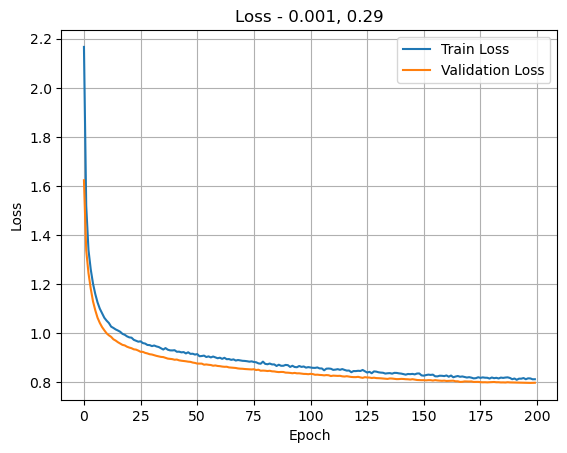

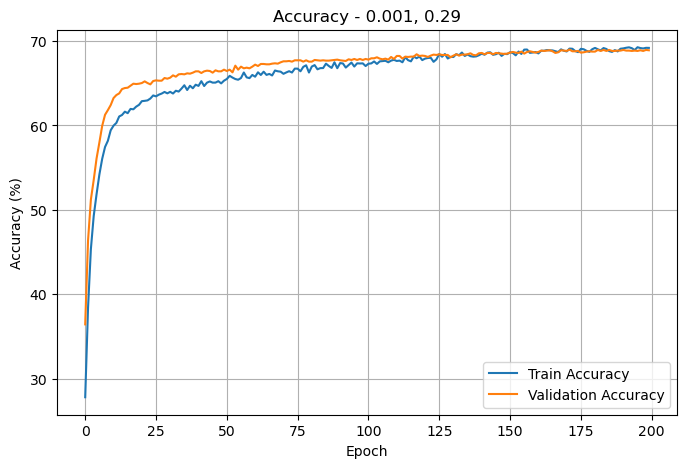

0.001 0.37 68.99009900990099 60.555914411915005 64.77300671090799


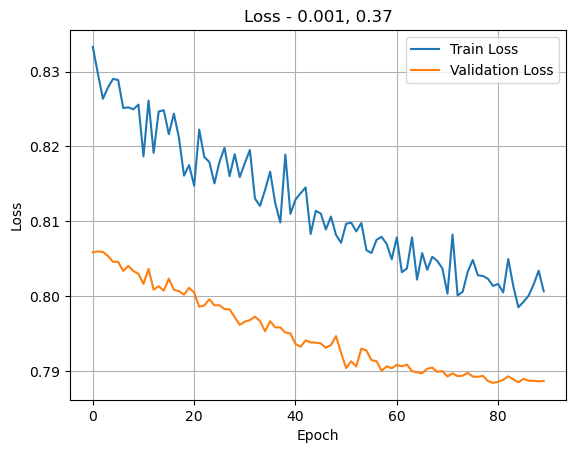

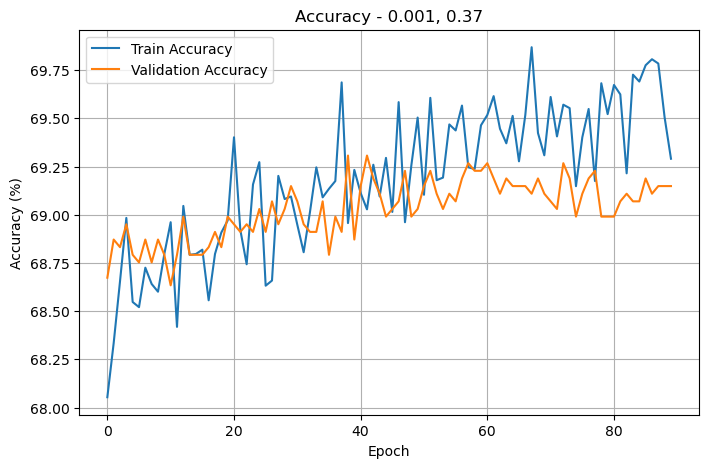

0.001 0.45 68.5940594059406 69.87939615437158 69.23672778015609


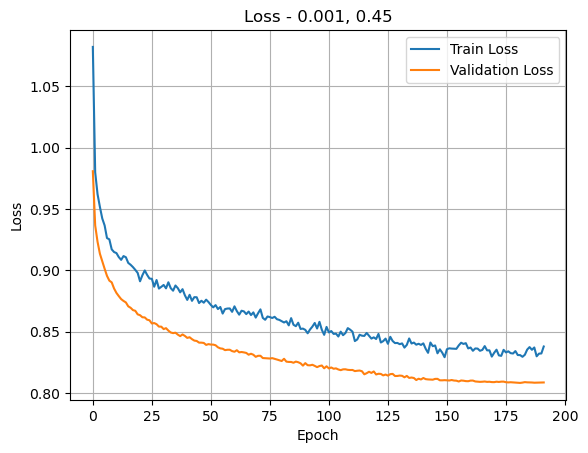

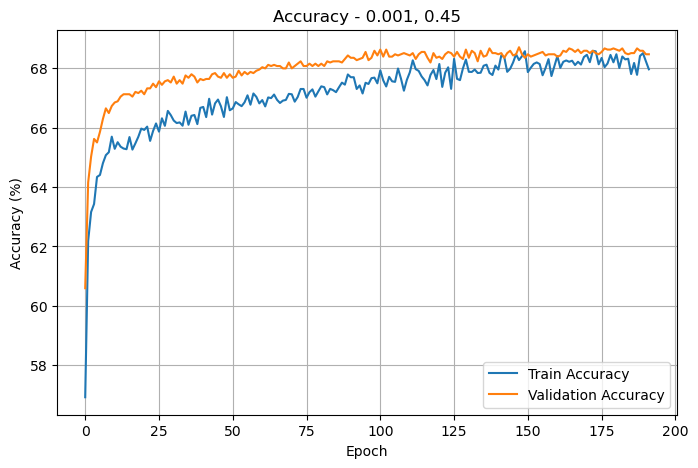

0.001 0.55 66.25742574257426 80.227951556078 73.24268864932613


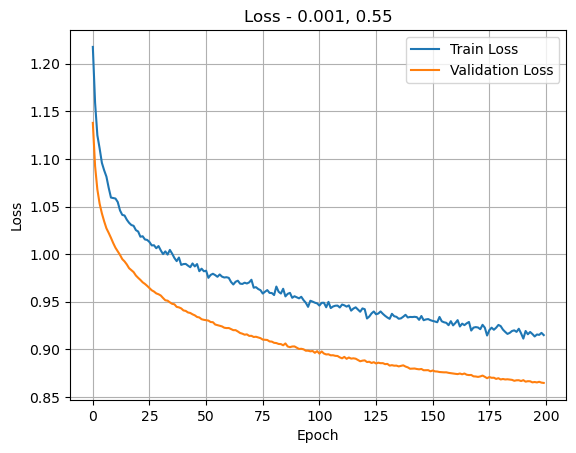

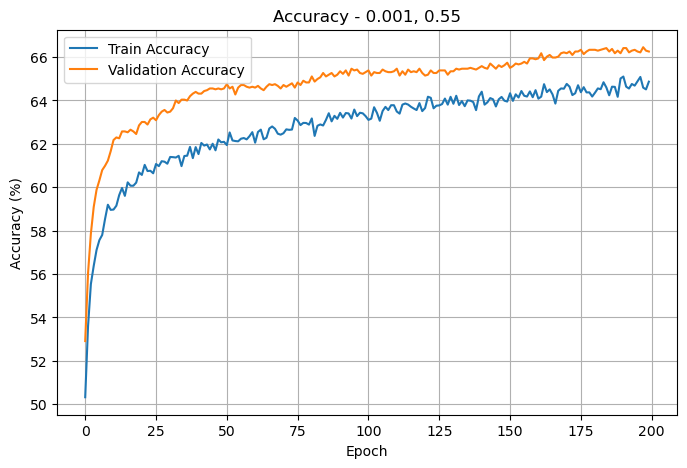

0.001 0.68 59.722772277227726 89.91909709866039 74.82093468794406


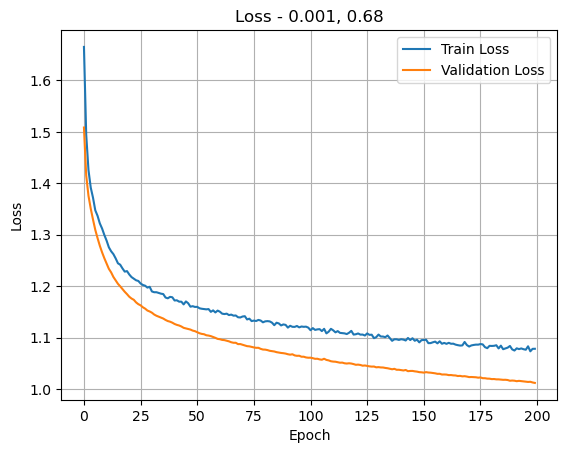

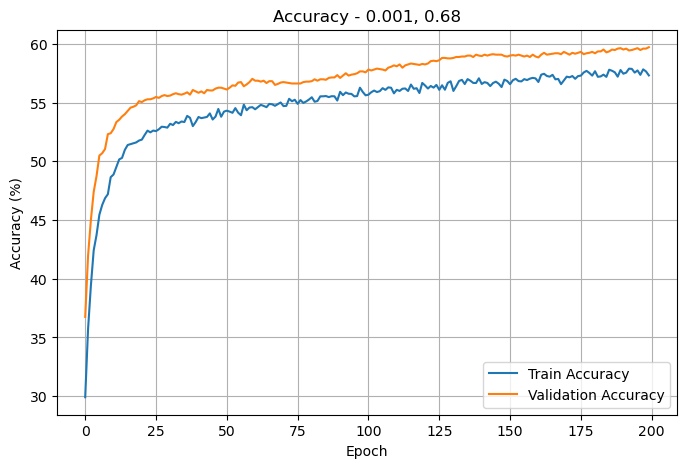

0.0001 0.29 74.17821782178218 50.118816122563594 62.148516972172885


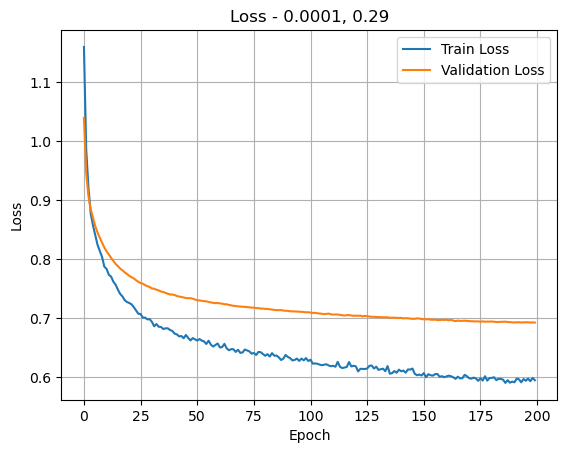

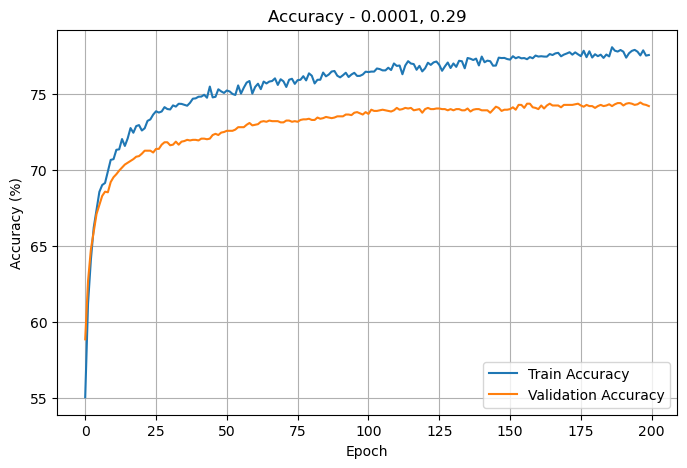

0.0001 0.37 72.1980198019802 60.555914411915005 66.3769671069476


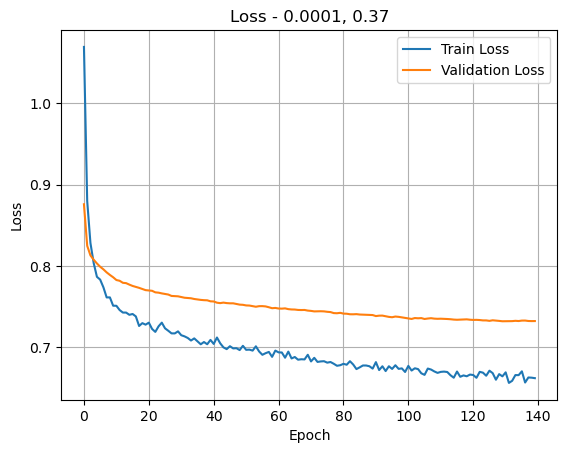

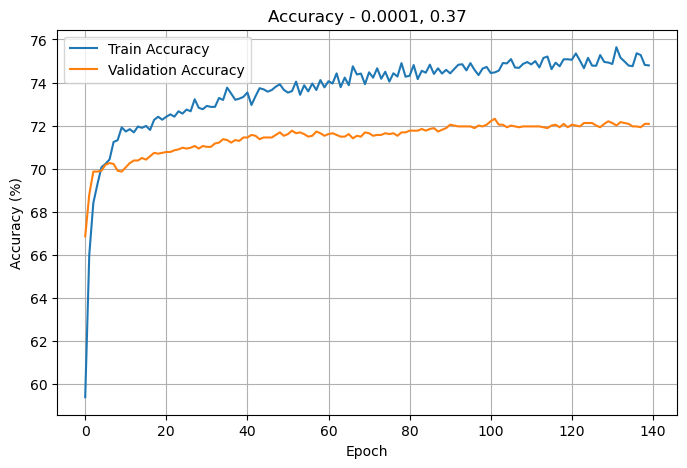

0.0001 0.45 71.24752475247524 69.87939615437158 70.5634604534234


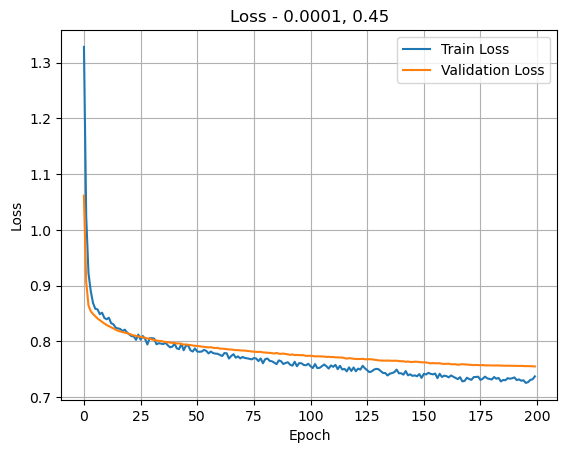

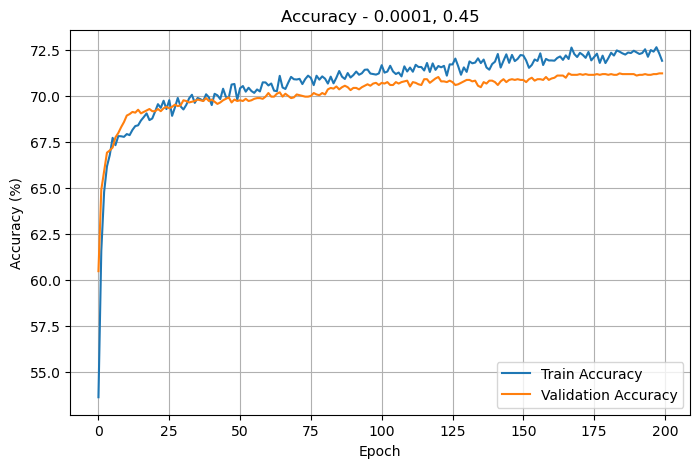

0.0001 0.55 67.48514851485149 80.227951556078 73.85655003546475


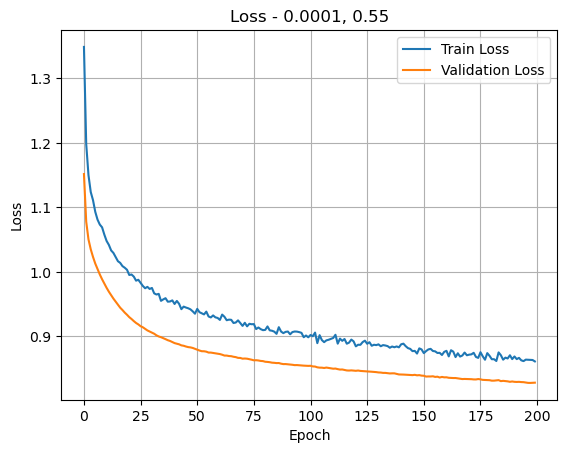

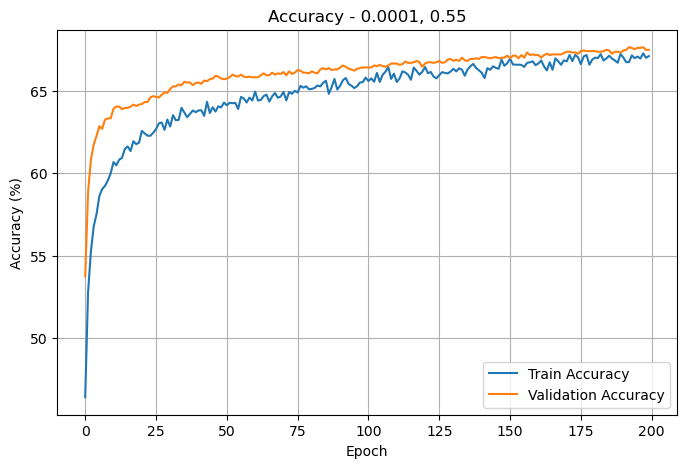

0.0001 0.68 61.26732673267327 89.91909709866039 75.59321191566683


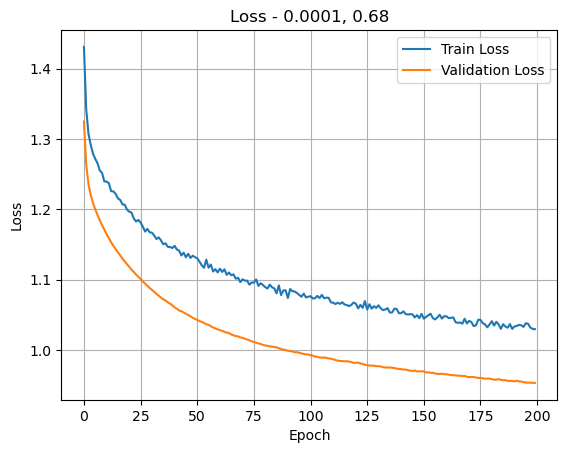

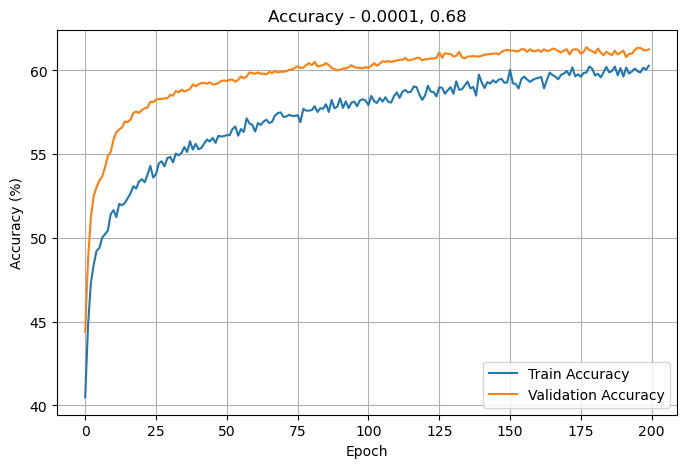

1e-05 0.29 71.52475247524752 50.118816122563594 60.821784298905555


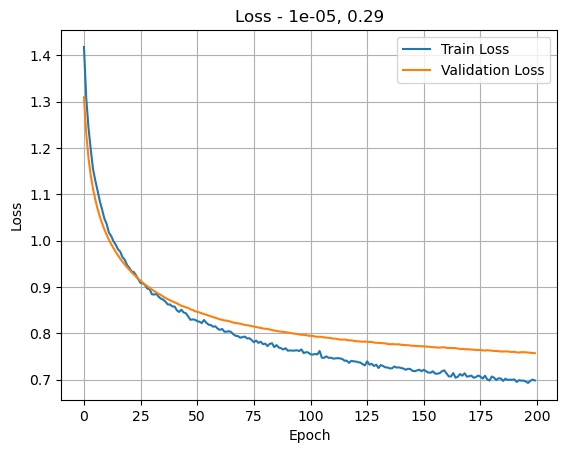

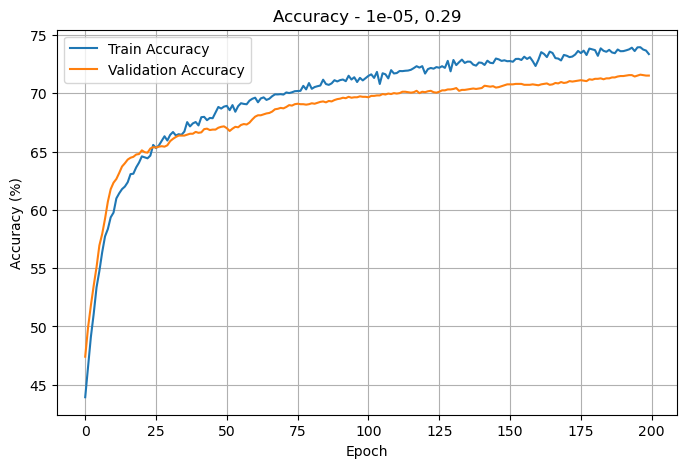

1e-05 0.37 71.32673267326733 60.555914411915005 65.94132354259116


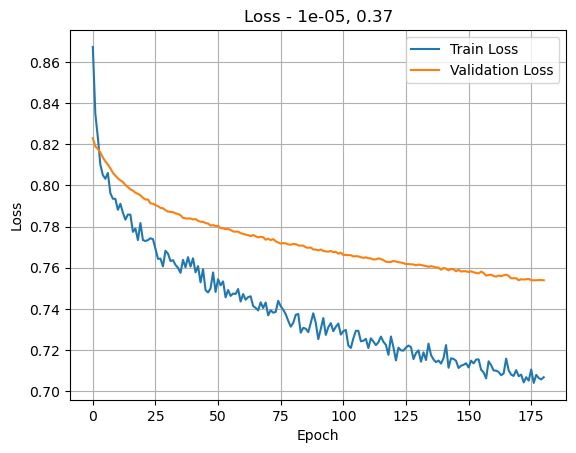

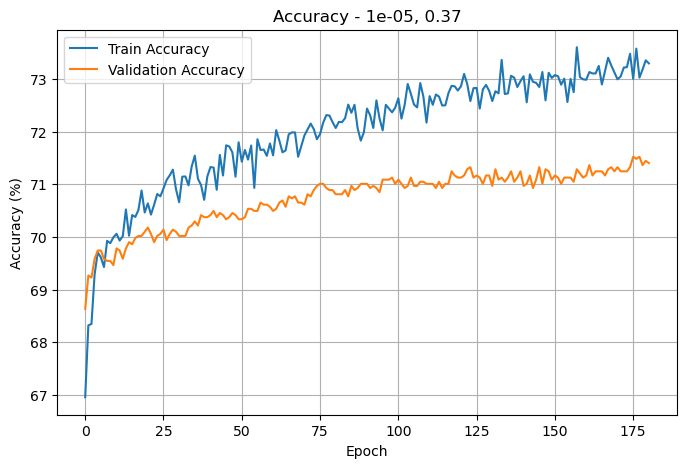

1e-05 0.45 69.66336633663366 69.87939615437158 69.77138124550262


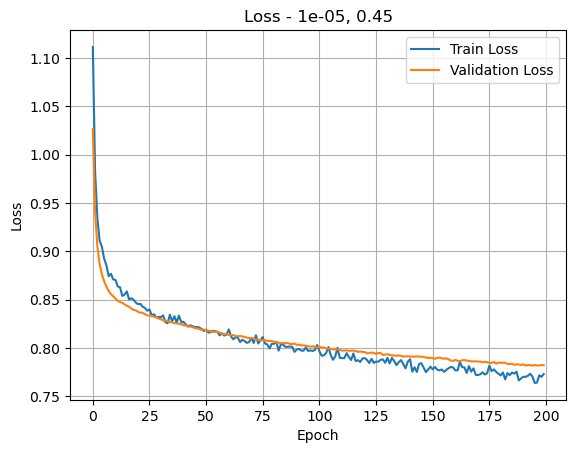

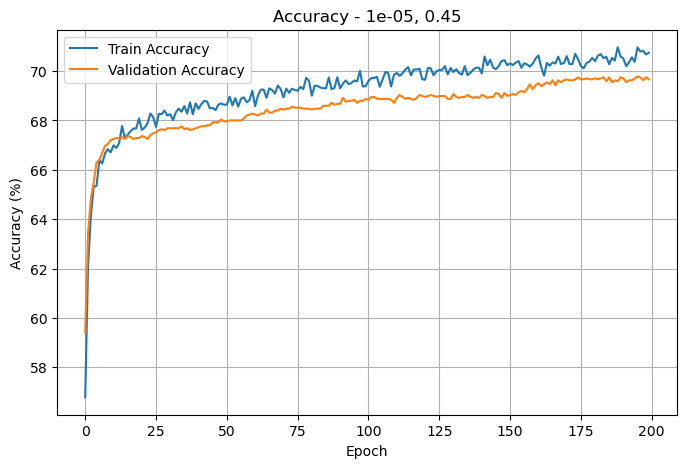

1e-05 0.55 66.77227722772277 80.227951556078 73.50011439190038


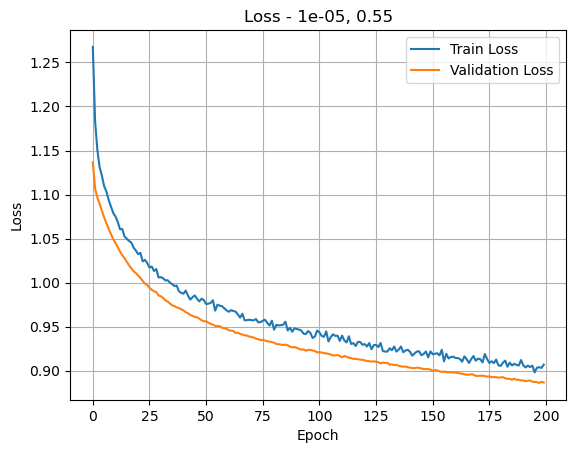

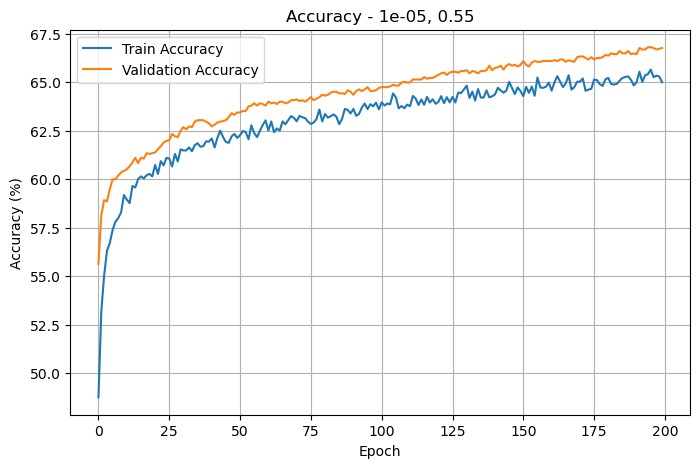

1e-05 0.68 59.24752475247525 89.91909709866039 74.58331092556782


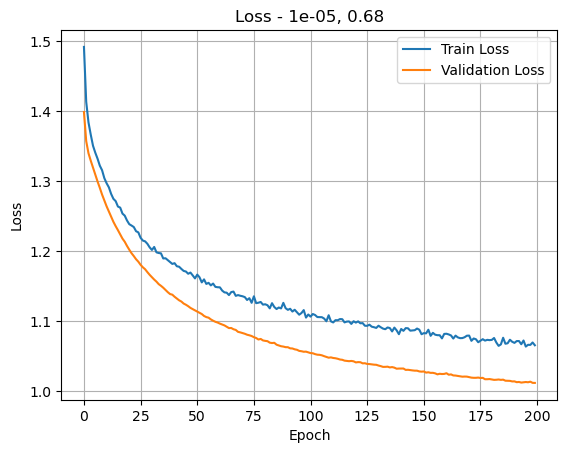

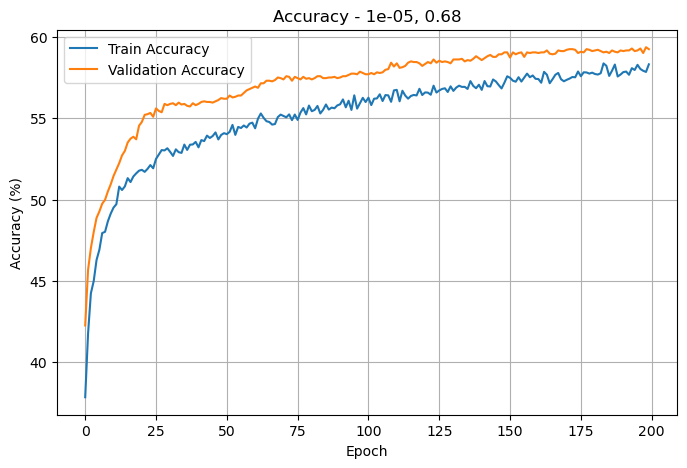

In [19]:
criterion = torch.nn.CrossEntropyLoss()
results = {}
for reg_weight in [1e-3,1e-4,1e-5]:
    for pruning_ratio in [round(1-(1-i)**(1/2),2) for i in [0.5, 0.6, 0.7, 0.8, 0.9]]:
        checkpoint = torch.load(f'pruned_checkpoint_{reg_weight}_{pruning_ratio}.pt')
        model = ConvNet()
        model.to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        zero_count = 0
        total_count = 0
        for k, v in model.state_dict().items():
            if torch.is_tensor(v):
                zeros = (v == 0).sum().item()
                total = v.numel()
                zero_count += zeros
                total_count += total
        sparsity = zero_count/total_count*100
        val_loss, val_accuracy = validate(model, val_loader, criterion, device, 0)
        print(reg_weight, pruning_ratio, val_accuracy, sparsity, (val_accuracy+sparsity)/2)
        results[(reg_weight, pruning_ratio)] = (val_accuracy, sparsity)
        
        plt.plot(checkpoint['train_losses'], label='Train Loss')
        plt.plot(checkpoint['val_losses'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss - {reg_weight}, {pruning_ratio}')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.figure(figsize=(8,5))
        plt.plot(checkpoint['train_accuracies'], label='Train Accuracy')
        plt.plot(checkpoint['val_accuracies'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy - {reg_weight}, {pruning_ratio}')
        plt.legend()
        plt.grid(True)
        plt.show()

In [29]:
reg_weight, pruning_ratio = 0.0001, 0.68
checkpoint = torch.load(f'pruned_checkpoint_{reg_weight}_{pruning_ratio}.pt')
torch.save(checkpoint['model_state_dict'], f'pruned_weights_{reg_weight}_{pruning_ratio}.pt')

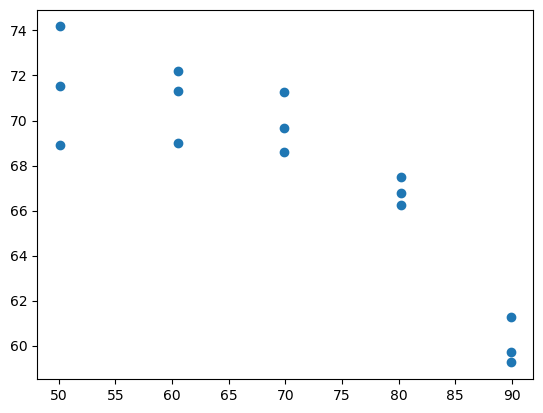

In [25]:
plt.scatter([v[1] for v in results.values()],[v[0] for v in results.values()])

In [26]:
import csv

with open('results_depgraph.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['sparsity', 'accuracy'])  # header
    for v in results.values():
        csv_writer.writerow([v[1], v[0]])
